# **Propensity models for churn (students dropout)**

## **Business context**
###Study X collaborates with universities to support international students' transition into higher education. To improve student retention, the company leverages data-driven insights to identify at-risk students and predict drop-out risks. By analysing course-level data, Study X aims to enhance academic support, personalise learning pathways, and improve student success rates. This proactive approach helps universities implement targeted interventions, ensuring a smoother educational journey for students.

## **Objective**
###Advanced machine learning techniques are applied to create a predictive model for student dropout. My work will employ and compare multiple predictive algorithms - XGBoost and neural network-based model, to determine the most effective model for predicting student dropout.

## **Data**
###A dataset of students’ features is used. The data is filtered, processed, transformed and analysed. Models are compared using a filtered table that excludes ContactHours and AttendancePercentage, and a new table including them.







## **1.** Importing the required libraries and data set with the provided URL.

In [ ]:
!pip install shap

# Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import shap
from tensorflow import keras
from tensorflow.keras import layers, models
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, classification_report, ConfusionMatrixDisplay, roc_curve

from keras.models import Sequential
from keras.layers import Dense
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

seed = 42

## **2.** Read the course-level csv file and make it available as a dataframe.

In [ ]:
# Read the CSV file into a new DataFrame.
customer_data = pd.read_csv('/content/CUSTOMERS_data.csv')

df=customer_data.copy()

In [ ]:
# Check for duplicates
duplicate_count = df.duplicated().sum()

print(f'Number of duplicate rows: {duplicate_count}')

Number of duplicate rows: 0


There are no duplicates in the original dataset so we keep all the observations.

## **3.** From the dataframe, removing pre-identified (by the business) columns.

For now I am still keeping the two extra variables that we have to add later on to the models 'ContactHours',	'AttendancePercentage'

In [ ]:
# List of columns to remove
columns_to_remove = ['BookingId', 'BookingType', 'LeadSource', 'DiscountType', 'Nationality', 'HomeCountry', 'HomeState', 'HomeCity', 'PresentCount', 'LateCount', 'AuthorisedAbsenceCount', 'ArrivedDate', 'NonCompletionReason', 'TerminationDate', 'CourseFirstIntakeDate', 'CourseStartDate', 'CourseEndDate', 'AcademicYear', 'CourseName', 'LearnerCode', 'ProgressionDegree', 'EligibleToProgress', 'AssessedModules', 'PassedModules', 'FailedModules']

df = df.drop(columns=columns_to_remove)
df.head()

,CentreName,DateofBirth,Gender,CourseLevel,IsFirstIntake,CompletedCourse,CreditWeightedAverage,ProgressionUniversity,UnauthorisedAbsenceCount,ContactHours,AttendancePercentage
0,ISC_Aberdeen,13/01/1998,Male,Pre-Masters,True,Yes,75.0,University of Aberdeen,NaN,NaN,NaN
1,ISC_Aberdeen,12/02/1998,Male,Foundation,False,Yes,73.0,University of Aberdeen,5.0,215.0,97.0
2,ISC_Aberdeen,07/04/2000,Male,International Year Two,False,Yes,66.0,University of Aberdeen,6.0,226.0,97.0
3,ISC_Aberdeen,18/05/1999,Male,International Year Two,True,Yes,71.0,University of Aberdeen,15.0,399.0,94.0
4,ISC_Aberdeen,19/04/1996,Male,Pre-Masters,True,Yes,60.0,University of Aberdeen,NaN,NaN,NaN


**Check categorical variables data**

In [ ]:
Gender_counts = df['Gender'].value_counts()
print("\nGender Counts:\n", Gender_counts)


Gender Counts:
 Gender
Male      15655
Female     9404
Name: count, dtype: int64


In [ ]:
centre_name_counts = df['CentreName'].value_counts()
print("\nCentreName Counts:\n", centre_name_counts)


CentreName Counts:
 CentreName
ISC_Sheffield       5877
ISC_Durham          2570
ISC_Leeds           2295
ISC_Sussex          2103
ISC_Kingston        1892
ISC_Huddersfield    1781
ISC_Lancaster       1084
ISC_Surrey          1051
ISC_RHUL            1046
ISC_LJMU             951
ISC_London           930
ISC_Cardiff          687
ISC_Strathclyde      670
ISC_Teesside         632
ISC_Holland          436
ISC_Dublin           399
ISC_Aberdeen         361
ISC_Lincoln          241
ISC_Online            53
Name: count, dtype: int64


**Renaming variables values to simplify data read**

In [ ]:
# Remove the prefix 'ISC_' from the 'name' column
df['CentreName'] = df['CentreName'].str.replace('ISC_', '', regex=False)

In [ ]:
CourseLevel_counts = df['CourseLevel'].value_counts()
print("\CourseLevel Counts:\n", CourseLevel_counts)

\CourseLevel Counts:
 CourseLevel
Foundation                14666
Pre-Masters                5905
International Year One     4441
International Year Two       47
Name: count, dtype: int64


In [ ]:
# Define a mapping of old values to new values
rename_map = {
'Foundation': 'FND',
'Pre-Masters': 'PRM',
'International Year One': 'IYO',
'International Year Two': 'IYT'
}
df['CourseLevel'] = df['CourseLevel'].replace(rename_map)

In [ ]:
# Define a mapping of old values to new values
rename_map = {
'University of Sheffield International College': 'USI',
'Durham University': 'DUU',
'University of Sussex': 'USS',
'Kingston University London': 'KUL',
'University of Huddersfield': 'UHU',
'University of Leeds': 'ULE',
'Lancaster University': 'LAU',
'University of Surrey': 'USR',
'Royal Holloway': 'RHO',
'Liverpool John Moores University': 'LMU',
'Coventry University London': 'CUL',
'Leeds Beckett University': 'LBU',
'Cardiff University': 'CAU',
'University of Strathclyde': 'UST',
'Teesside University': 'TEU',
'University College Dublin': 'UCD',
'University of Aberdeen': 'UAB',
'University of Lincoln': 'ULI',
'Holland ISC - VU Amsterdam': 'HVA',
'Holland ISC - Tilburg University': 'HTU',
'Holland ISC - Erasmus University Rotterdam': 'HUR',
'VU Amsterdam': 'VUA',
'Holland ISC - Hanze UAS': 'HHU',
'Tilburg University': 'TIU',
'Erasmus Rotterdam': 'ERO',
'Hanze UAS': 'HAU',
'UK Online Pathways': 'UOP',
'Strathclyde University': 'STU',
'Holland ISC - Erasmus University Rotterdam/ Holland ISC - Tilburg University': 'HET',
'Outside of partnership': 'OOP',
'Holland ISC - Erasmus University Rotterdam/Holland ISC - VU Amsterdam': 'HEA',
'Holland ISC - Erasmus University Rotterdam/ Tilburg University': 'HER',
'HULT Business School': 'HBS',
'Holland ISC - Erasmus University Rotterdam/Tilburg University': 'HER',
'Coventry University': 'COU',
'Holland ISC - Hanze UAS/VU Amsterdam': 'HHA',
'Keele University': 'KEU',
'Holland ISC - Tilburg University/VU Amsterdam/Hanze': 'HTA',
'Holland ISC - Erasmus University Rotterdam/Holland ISC - Tilburg University': 'HEH',
'Holland ISC - VU Amsterdam/ Military service': 'HVM'
}

df['ProgressionUniversity'] = df['ProgressionUniversity'].replace(rename_map)

**Converting DateofBirth to Age**

In [ ]:
df['DateofBirth'] = pd.to_datetime(df['DateofBirth'], format='%d/%m/%Y')
today = pd.Timestamp.today()
df['Age'] = (today - df['DateofBirth']).dt.days // 365
df = df.drop(columns=['DateofBirth'])


In [ ]:
print(df.shape)
df.dtypes

(25059, 11)


,0
CentreName,object
Gender,object
CourseLevel,object
IsFirstIntake,bool
CompletedCourse,object
CreditWeightedAverage,float64
ProgressionUniversity,object
UnauthorisedAbsenceCount,float64
ContactHours,float64
AttendancePercentage,float64


**Checking target variable distribution**

In [ ]:
total_counts = df['CompletedCourse'].value_counts()
percentage_counts = df['CompletedCourse'].value_counts(normalize=True) * 100

print("Total counts of CompletedCourse variable:")
print(total_counts)

print("\nPercentage counts of CompletedCourse variable:")
print(percentage_counts)

Total counts of CompletedCourse variable:
CompletedCourse
Yes    21305
No      3754
Name: count, dtype: int64

Percentage counts of CompletedCourse variable:
CompletedCourse
Yes    85.019354
No     14.980646
Name: proportion, dtype: float64


🔍 Our target accounts for 15% of our observations.

**Checking missing values**

In [ ]:
# Find missing values.
missings_count = df.isnull().sum()

print(f'Missing values: {missings_count}')
print(df.shape)

Missing values: CentreName                     0
Gender                         0
CourseLevel                    0
IsFirstIntake                  0
CompletedCourse                0
CreditWeightedAverage       2296
ProgressionUniversity          0
UnauthorisedAbsenceCount     208
ContactHours                 208
AttendancePercentage         208
Age                            0
dtype: int64
(25059, 11)


🔍 The data shows that the two extra variables (ContactHours and AttendancePercentage) have the same number of missing values as UnauthorisedAbsenceCount. By checking the overlap in missing value we can establish if they all held missing data and if, by cleaning the 208 NAs from one variable, this will remove also the NAs on the other two:

In [ ]:
missing_overlap = df[['UnauthorisedAbsenceCount', 'ContactHours', 'AttendancePercentage']].isna().all(axis=1)
overlap_count = missing_overlap.sum()
print(f'Number of rows where all three columns have missing values: {overlap_count}')

Number of rows where all three columns have missing values: 208


💡 Upon request of the business we remove any observation that has any missing value: the code shows that the three variables have all missing values on the same rows, they overlap, so we can remove with confidence the NAs across all of them without impacting the number of rows if we were to chose only UnauthorisedAbsenceCount.

**Removing missing values**

In [ ]:
# Find missing values.
missings_count = df.isnull().sum()

print(f'Missing values: {missings_count}')
print(df.shape)

Missing values: CentreName                  0
Gender                      0
CourseLevel                 0
IsFirstIntake               0
CompletedCourse             0
CreditWeightedAverage       0
ProgressionUniversity       0
UnauthorisedAbsenceCount    0
ContactHours                0
AttendancePercentage        0
Age                         0
dtype: int64
(22686, 11)


All missing values have been removed.

**Checking target variable new distribution**

In [ ]:
total_counts = df['CompletedCourse'].value_counts()
percentage_counts = df['CompletedCourse'].value_counts(normalize=True) * 100

# Display the total and percentage counts
print("Total counts of CompletedCourse variable:")
print(total_counts)

print("\nPercentage counts of CompletedCourse variable:")
print(percentage_counts)

Total counts of CompletedCourse variable:
CompletedCourse
Yes    21242
No      1444
Name: count, dtype: int64

Percentage counts of CompletedCourse variable:
CompletedCourse
Yes    93.634841
No      6.365159
Name: proportion, dtype: float64


🔍 After removing rows with NAs, I reduce the size of the target to 6.4% (from 3,754 to 1,444 observations). I will progress with this new data split, as the approach of filtering out these observations is aligned with requirements.

**Computing Target variable**

Converting target variable to binary. Student dropout is the target so we encode CompletedCourse and any No is our target for dropout.




In [ ]:
# Creating the target variable manually based on the condition
df['target'] = df['CompletedCourse'].apply(lambda x: 1 if x == 'No' else 0)

print(df[['CompletedCourse', 'target']].head())

  CompletedCourse  target
1             Yes       0
2             Yes       0
3             Yes       0
5             Yes       0
7             Yes       0


In [ ]:
df = df.drop(columns=['CompletedCourse'])
total_counts = df['target'].value_counts()
percentage_counts = df['target'].value_counts(normalize=True) * 100

print("Total counts of target variable:")
print(total_counts)

print("\nPercentage counts of target variable:")
print(percentage_counts)

Total counts of target variable:
target
0    21242
1     1444
Name: count, dtype: int64

Percentage counts of target variable:
target
0    93.634841
1     6.365159
Name: proportion, dtype: float64


**💡Applying One Hot Encoding on categorical variables**: CentreName, Gender, CourseLevel, IsFirstIntake, ProgressionUniversity

In [ ]:
## Renaming variables first to reduce lables strings
new_column_names = {
'CentreName': 'CEN',
'Gender': 'GND',
'CourseLevel': 'CRL',
'IsFirstIntake': 'IFI',
'CompletedCourse': 'COC',
'CreditWeightedAverage': 'CWA',
'ProgressionUniversity': 'PRU',
'UnauthorisedAbsenceCount': 'UAC',
'ContactHours': 'COH',
'AttendancePercentage': 'ATP',
'Age': 'Age'
}

df.rename(columns=new_column_names, inplace=True)

In [ ]:
df_encoded = df.copy()
df_encoded = pd.get_dummies(df_encoded, columns=['CEN', 'GND', 'CRL', 'IFI', 'PRU'], drop_first=True)
df_encoded.columns = df_encoded.columns.str.lower()
df_encoded = df_encoded.astype(float)
df_encoded.head()

,cwa,uac,coh,atp,age,target,cen_cardiff,cen_dublin,cen_durham,cen_holland,...,pru_ucd,pru_uhu,pru_ule,pru_uli,pru_uop,pru_usi,pru_usr,pru_uss,pru_ust,pru_vua
1,73.0,5.0,215.0,97.0,26.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,66.0,6.0,226.0,97.0,24.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,71.0,15.0,399.0,94.0,25.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,78.0,3.0,371.0,99.0,24.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,68.0,25.0,214.0,86.0,22.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Target variable histogram**

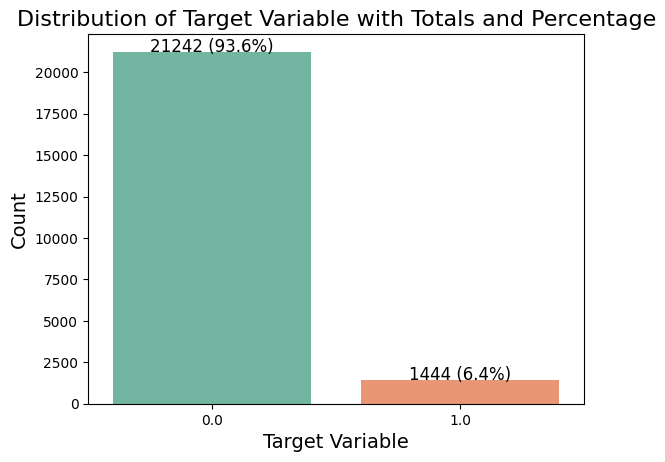

In [ ]:
sns.set_palette("pastel")
sns.countplot(x='target', data=df_encoded, palette='Set2')
total_counts = df_encoded['target'].value_counts()
total = total_counts.sum()
percentages = (total_counts / total) * 100

plt.title('Distribution of Target Variable with Totals and Percentage', fontsize=16)
plt.xlabel('Target Variable', fontsize=14)
plt.ylabel('Count', fontsize=14)

for i, (count, percentage) in enumerate(zip(total_counts, percentages)):
    plt.text(i, count + 0.5, f'{count} ({percentage:.1f}%)', ha='center', fontsize=12)

plt.show()

🔍 The target variable looks fairly imbalanced with 6.4% total drop-outs to be predicted over the total sample.

###**Exploratory Data Analysis**

In [ ]:
df.describe()

,CWA,UAC,COH,ATP,Age,target
count,22686.000000,22686.000000,22686.000000,22686.000000,22686.000000,22686.000000
mean,62.794940,37.692498,394.387199,84.847263,23.776779,0.063652
std,19.324465,37.176733,106.447228,15.625485,3.202377,0.244137
min,0.000000,0.000000,44.000000,1.000000,18.000000,0.000000
25%,60.000000,11.000000,334.000000,80.000000,22.000000,0.000000
50%,67.000000,27.000000,398.000000,89.000000,23.000000,0.000000
75%,74.000000,52.000000,483.000000,96.000000,26.000000,0.000000
max,98.000000,343.000000,792.000000,100.000000,62.000000,1.000000


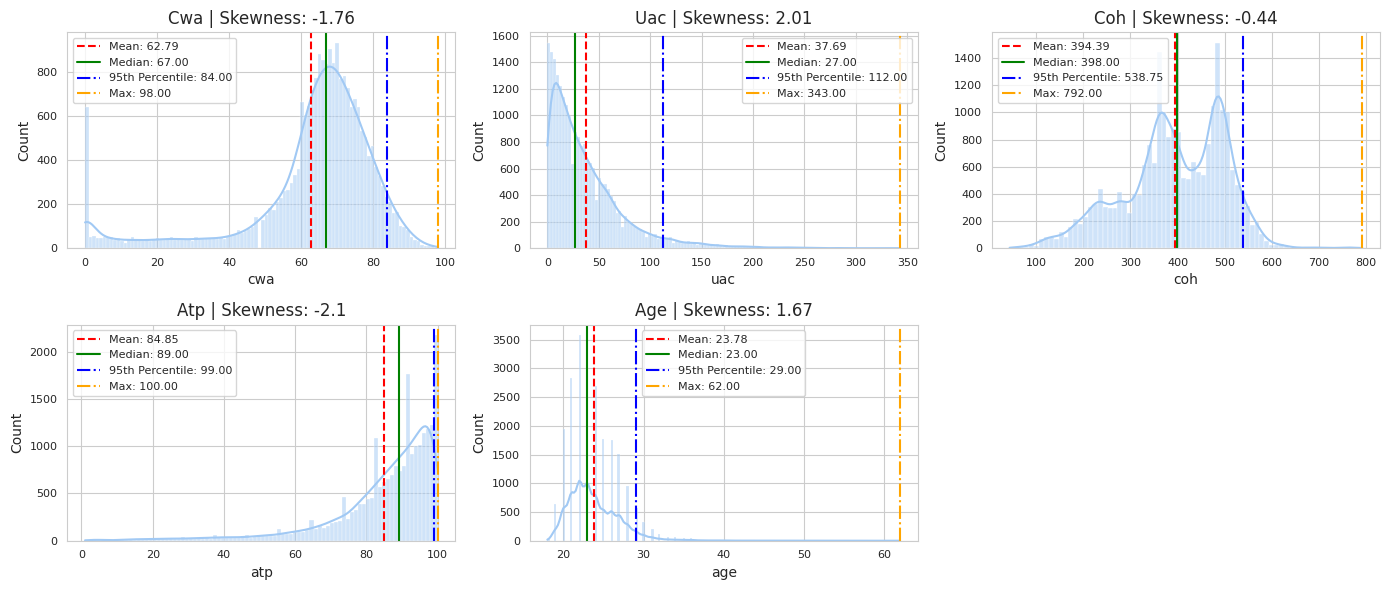

In [ ]:
selected_features = ['cwa', 'uac', 'coh', 'atp', 'age']

sns.set_style("whitegrid")
sns.set_palette("pastel")

plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=8)

num_cols = 3
num_rows = (len(selected_features) + 1) // num_cols

plt.figure(figsize=(14, num_rows * 3))

for idx, feature in enumerate(selected_features, 1):
    plt.subplot(num_rows, num_cols, idx)

    # Plot histogram with KDE
    sns.histplot(df_encoded[feature], kde=True)

    # Calculate statistics
    mean_val = df_encoded[feature].mean()
    median_val = df_encoded[feature].median()
    perc_95th = np.percentile(df_encoded[feature], 95)
    max_val = df_encoded[feature].max()

    # Plot lines for mean, median, 95th percentile, and max
    plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    plt.axvline(perc_95th, color='blue', linestyle='-.', label=f'95th Percentile: {perc_95th:.2f}')
    plt.axvline(max_val, color='orange', linestyle='-.', label=f'Max: {max_val:.2f}')

    plt.title(f"{feature.capitalize()} | Skewness: {round(df_encoded[feature].skew(), 2)}")
    plt.legend()

plt.tight_layout()
plt.show()

### **Plot boxplots of the input features, grouped by target variable.**

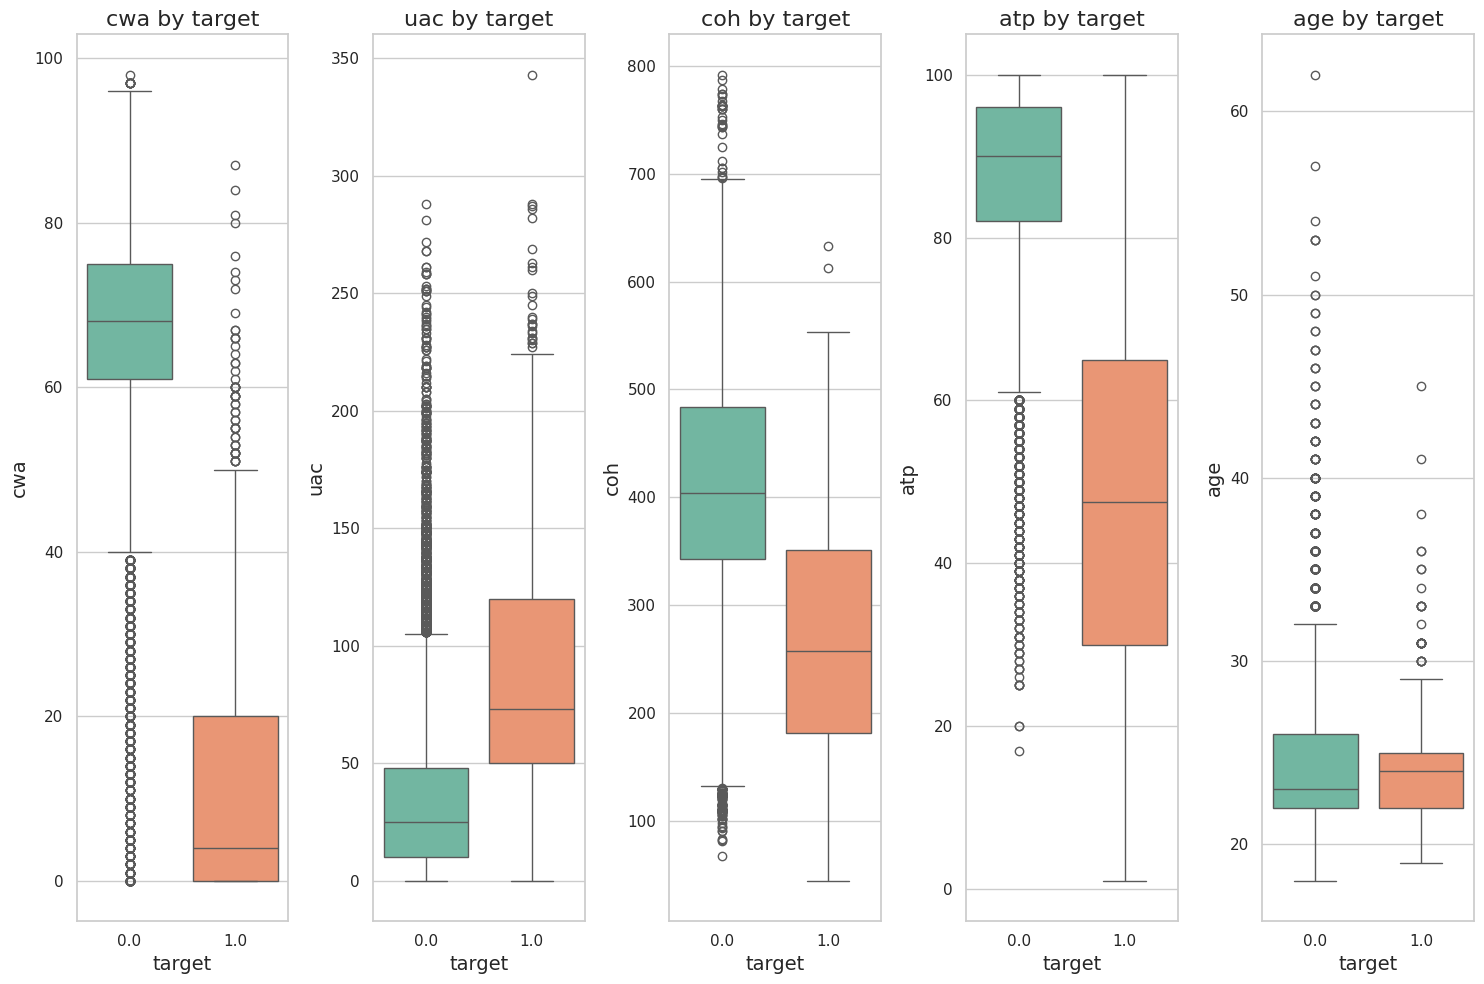

In [ ]:
sns.set(style="whitegrid")

selected_features = ['cwa', 'uac', 'coh', 'atp', 'age']
target_variable = 'target'

num_features = len(selected_features)
num_rows = int(num_features / 5) + (num_features % 5 > 0)
num_cols = 5

plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x=target_variable, y=feature, data=df_encoded, palette="Set2")
    plt.title(f'{feature} by {target_variable}', fontsize=16)
    plt.xlabel(target_variable, fontsize=14)
    plt.ylabel(feature, fontsize=14)

plt.tight_layout()
plt.show()

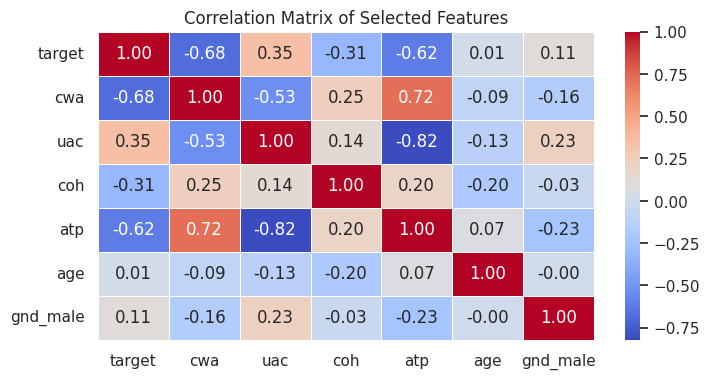

In [ ]:
selected_features = ['target','cwa', 'uac', 'coh', 'atp', 'age', 'gnd_male']
correlation_data = df_encoded[selected_features]
correlation_matrix = correlation_data.corr()
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Matrix of Selected Features', fontsize=12)

plt.show()

###🔍 As a preliminary analysis of possible drivers of churn, the boxplots and correlation matrix indicate that certain variables, like CreditWeightedAverage (cwa) and AttendancePercentage (atp), are negatively correlated with dropout, meaning higher scores reduce the likelihood of dropout. In contrast, UnauthorisedAbsenceCount (uac) shows a positive correlation with dropout:

###**Computing train and test samples and scaling the data**

In [ ]:
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

print(X.shape)
print(y.shape)

(22686, 65)
(22686,)


In [ ]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True, stratify=y, random_state=seed)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2, shuffle=True, stratify=y_train, random_state=seed)

In [ ]:
def display_counts_and_percentages(y_data, data_name):
    counts = y_data.value_counts()
    percentages = y_data.value_counts(normalize=True) * 100

    df_output = pd.DataFrame({
        f'{data_name} Counts': counts,
        f'{data_name} Percentages (%)': percentages
    })

    return df_output

# Check counts and percentages for y_train, y_test, y_val
train_table = display_counts_and_percentages(y_train, "Training Set")
test_table = display_counts_and_percentages(y_test, "Test Set")
val_table = display_counts_and_percentages(y_val, "Val Set")

output_table = pd.concat([train_table, test_table, val_table], axis=1)

output_table

,Training Set Counts,Training Set Percentages (%),Test Set Counts,Test Set Percentages (%),Val Set Counts,Val Set Percentages (%)
target,,,,,,
0.0,13594,93.635487,4249,93.631556,3399,93.636364
1.0,924,6.364513,289,6.368444,231,6.363636


**Check data distribution between samples**

**1) Train sample**

In [ ]:
selected_features = ['cwa', 'uac', 'coh', 'atp', 'age']

# Convert X_train back to a DataFrame, ensuring it has the correct columns
X_train_check = pd.DataFrame(X_train, columns=df_encoded.drop('target', axis=1).columns)
X_train_selected = X_train_check[selected_features]
X_train_selected.describe()

,cwa,uac,coh,atp,age
count,14518.000000,14518.000000,14518.000000,14518.000000,14518.000000
mean,62.805276,37.554760,393.952817,84.890550,23.766772
std,19.348720,37.256234,106.232537,15.616757,3.187838
min,0.000000,0.000000,49.000000,1.000000,18.000000
25%,60.000000,11.000000,334.000000,80.000000,22.000000
50%,67.000000,27.000000,398.000000,89.000000,23.000000
75%,74.000000,52.000000,482.000000,96.000000,26.000000
max,97.000000,343.000000,792.000000,100.000000,62.000000


**2) Validation Sample**

In [ ]:
selected_features = ['cwa', 'uac', 'coh', 'atp', 'age']

# Convert X_val back to a DataFrame, ensuring it has the correct columns
X_val_check = pd.DataFrame(X_val, columns=df_encoded.drop('target', axis=1).columns)
X_val_selected = X_val_check[selected_features]

X_val_selected.describe()

,cwa,uac,coh,atp,age
count,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000
mean,62.824518,36.730579,393.582094,85.000275,23.758402
std,19.196172,35.235094,107.048974,15.499873,3.153076
min,0.000000,0.000000,44.000000,3.000000,18.000000
25%,59.000000,11.000000,333.000000,80.000000,22.000000
50%,67.000000,27.000000,397.000000,89.000000,23.000000
75%,74.000000,51.000000,483.000000,96.000000,26.000000
max,96.000000,287.000000,768.000000,100.000000,51.000000


**Computing filtered datasets to remove the two required variables: ContactHours coh and AttendancePercentage atp**

In [ ]:
# Step 4: Create a train/test split excluding 'coh' and 'atp'
X_f_train = X_train.drop(columns=['coh', 'atp'], errors='ignore')
X_f_test = X_test.drop(columns=['coh', 'atp'], errors='ignore')
X_f_val = X_val.drop(columns=['coh', 'atp'], errors='ignore')

### **Standardise numeric variables**

In [ ]:
# ALL VARIABLES
# Standardise the features.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled=scaler.transform(X_val)

In [ ]:
# FILTERED DATASET
# Standardise the features.
scaler = StandardScaler()
X_train_f_scaled = scaler.fit_transform(X_f_train)
X_test_f_scaled = scaler.transform(X_f_test)
X_val_f_scaled=scaler.transform(X_f_val)

**Dataset for Neural Networks (scaled data):**

*ALL VARIABLES*

X_train_scaled

X_test_scaled

X_val_scaled

*FILTERED DATASET*

X_train_f_scaled

X_test_f_scaled

X_val_f_scaled

**Dataset for XGBoost:**

*ALL VARIABLES*

X_train

X_test

X_val

*FILTERED DATASET*

X_f_train

X_f_test

X_f_val

In [ ]:
## Checking data samples shapes
datasets = {
    "X_train": X_train,
    "X_test": X_test,
    "X_val": X_val,
    "X_f_train": X_f_train,
    "X_f_test": X_f_test,
    "X_f_val": X_f_val,
    "X_train_scaled": X_train_scaled,
    "X_test_scaled": X_test_scaled,
    "X_val_scaled": X_val_scaled,
    "X_train_f_scaled": X_train_f_scaled,
    "X_test_f_scaled": X_test_f_scaled,
    "X_val_f_scaled": X_val_f_scaled
}

for dataset_name, dataset in datasets.items():
    print(f"{dataset_name} shape: {dataset.shape}")

X_train shape: (14518, 65)
X_test shape: (4538, 65)
X_val shape: (3630, 65)
X_f_train shape: (14518, 63)
X_f_test shape: (4538, 63)
X_f_val shape: (3630, 63)
X_train_scaled shape: (14518, 65)
X_test_scaled shape: (4538, 65)
X_val_scaled shape: (3630, 65)
X_train_f_scaled shape: (14518, 63)
X_test_f_scaled shape: (4538, 63)
X_val_f_scaled shape: (3630, 63)


#**Part 1.** Models with filtered data

##**Neural Network model**


###📈 Baseline model

###An initial Neural Network baseline model is trained to predict students dropout. Early stopping is also applied.

Here are its distinct **parameters**:

*   Total number of input variables **(63) as neurons**
*   Activation function **ReLU**
*   Optimizer **Adam**
*   **2 hidden layers**

I start with as many neurons as the input variables for hidden layers.



Training model_63_adam...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8332 - loss: 0.4668 - val_accuracy: 0.9694 - val_loss: 0.1133
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9681 - loss: 0.1096 - val_accuracy: 0.9727 - val_loss: 0.0857
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9683 - loss: 0.0857 - val_accuracy: 0.9736 - val_loss: 0.0778
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9705 - loss: 0.0828 - val_accuracy: 0.9730 - val_loss: 0.0828
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9674 - loss: 0.0823 - val_accuracy: 0.9716 - val_loss: 0.0786
Epoch 6/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9707 - loss: 0.0765 - val_accuracy: 0.9730 - val_loss: 0.0784
Epoch 7/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9685 - loss: 0.0775 - val_accuracy: 0.9733 - val_loss: 0.0753
Epoch 8/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9

<Figure size 400x200 with 0 Axes>

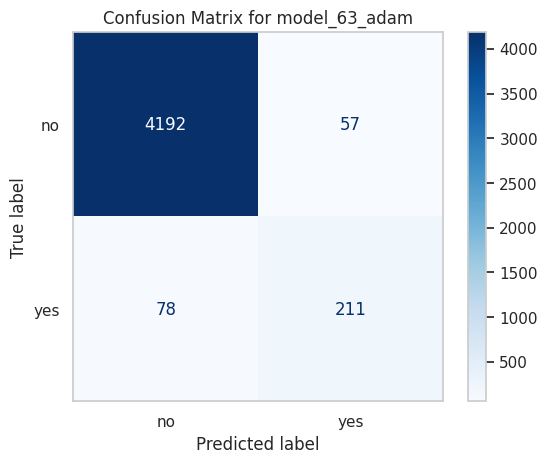

Test AUC for model_63_adam: 0.99


,model_name,train_accuracy,test_accuracy,test_loss,F1_score,precision,recall,AUC
0,model_63_adam,0.9723,0.9703,0.0702,0.9697,0.9694,0.9703,0.9862


In [ ]:
results_list = []

random_seed=seed

# **********  Defining the model architecture   **************
def create_model(hidden_neurons, optimizer, loss='binary_crossentropy', metrics=['accuracy'], l2_reg=None, dropout_rate=None, learning_rate=None):
    model = keras.models.Sequential([
        layers.Input(shape=(X_train_f_scaled.shape[1],)),

        # first hidden layer
        layers.Dense(63, activation='relu'),
        layers.BatchNormalization(),

        # second hidden layer
        layers.Dense(63, activation='relu'),
        layers.BatchNormalization(),

        # output layer
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model


model_histories = {}

hidden_neurons = 63
optimizer = 'adam'

model_name = f"model_{hidden_neurons}_{optimizer}"
print(f"\n\n{'='*50}\nTraining {model_name}...\n{'='*50}\n")

# Create an EarlyStopping callback
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0,
    restore_best_weights=True,
)

# **********  Creating the model  **************
model = create_model(hidden_neurons=hidden_neurons,
                     optimizer=optimizer,
                     learning_rate=0.001,
                   # l2_reg=0.01, dropout_rate=0.2,
)

# ********** Fitting the model **************
model_history = model.fit(X_train_f_scaled, y_train,
                          epochs=100,
                          batch_size=64,
                          validation_data=(X_val_f_scaled, y_val),
                          callbacks=[early_stopping_callback],
                          verbose=1)


model_histories = {model_name: model_history}
print(f"\n{model_name} has been trained.\n")

epochs_trained = len(model_history.history['loss'])
print(f"Training stopped after {epochs_trained} epochs due to early stopping.\n")


best_train_loss = min(model_history.history['loss'])
best_val_loss = min(model_history.history['val_loss'])
print(f"Best Training Loss: {best_train_loss:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")


# ********** Making predictions on the test set (probabilities) **************
y_test_pred = model.predict(X_test_f_scaled)
y_test_pred_classes = (y_test_pred > 0.5).astype("int32")


# ********** Model evaluation **************
test_accuracy = accuracy_score(y_test, y_test_pred_classes)
print(f"{model_name} Test Accuracy: {test_accuracy:.4f}\n")
print(classification_report(y_test, y_test_pred_classes))


# ********** Confusion Matrix **************
cm = confusion_matrix(y_test, y_test_pred_classes)
cfmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no", "yes"])

plt.figure(figsize=(4, 2))
cfmd.plot(cmap='Blues')
plt.grid(False)
plt.title(f"Confusion Matrix for {model_name}")
plt.show()


# ********** ROC and AUC **************
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"Test AUC for {model_name}: {roc_auc:.2f}")


# ********** Training accuracy and loss **************
train_loss = model_history.history['loss'][-1]
train_accuracy = model_history.history['accuracy'][-1]

test_loss = model.evaluate(X_test_f_scaled, y_test, verbose=0)[0]

# F1 Score, precision, recall
f1_score = classification_report(y_test, y_test_pred_classes, output_dict=True)['weighted avg']['f1-score']
precision = classification_report(y_test, y_test_pred_classes, output_dict=True)['weighted avg']['precision']
recall = classification_report(y_test, y_test_pred_classes, output_dict=True)['weighted avg']['recall']


results_list = [{
    "model_name": model_name,
    "train_accuracy": train_accuracy,
    "test_accuracy": test_accuracy,
    "test_loss": test_loss,
    "F1_score": f1_score,
    "precision": precision,
    "recall": recall,
    "AUC": roc_auc
}]

summary_df = pd.DataFrame(results_list)
summary_df = summary_df.round(4)

summary_df

###🔍 Fairly strong model results in predicting churn across all the metrics.

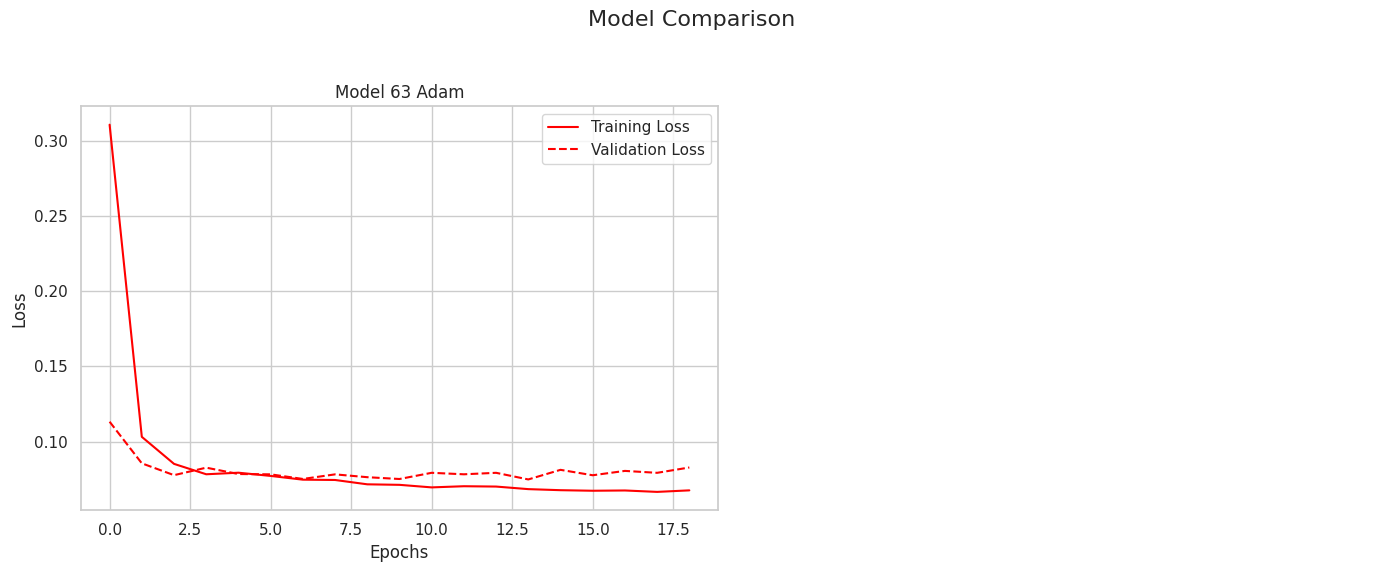

In [ ]:
# Plotting loss function
def plot_model_history(ax, history, title):
    ax.plot(history.history['loss'], label='Training Loss', color='red')
    ax.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

num_models = len(model_histories)
num_cols = 2
num_rows = (num_models + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 6 * num_rows))
fig.suptitle('Model Comparison', fontsize=16)

axs = axs.flatten()
for i, (model_name, history) in enumerate(model_histories.items()):
    plot_model_history(axs[i], history, model_name.replace('_', ' ').title())

for j in range(i + 1, num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

###🔍 The model shows strong results, with around 97% recall, good precision, and F1 score. Some overfitting is evident in the loss curve, as validation loss continues to rise.  

###I try hyperparameters tuning to check if model generalisation can improve and if loss can be reduced.

### **Initial model and Hyperparameters tuning**

**Hyperparameters:**
- reducing number of neurons to **16 and 32**
- optimizers: **adam, rmsprop**
- activation functions: **relu, tanh**

Including also **l2_reg=0.01**, **dropout_rate=0.2** to help with overfitting.



Training model_relu_16_adam...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7074 - loss: 0.6336 - precision_32: 0.1427 - recall_32: 0.5905 - val_accuracy: 0.9595 - val_loss: 0.2358 - val_precision_32: 0.7234 - val_recall_32: 0.5887
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9593 - loss: 0.1980 - precision_32: 0.6838 - recall_32: 0.7293 - val_accuracy: 0.9711 - val_loss: 0.1118 - val_precision_32: 0.8539 - val_recall_32: 0.6580
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9692 - loss: 0.1058 - precision_32: 0.7874 - recall_32: 0.7015 - val_accuracy: 0.9713 - val_loss: 0.0899 - val_precision_32: 0.8396 - val_recall_32: 0.6797
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9697 - loss: 0.0897 - precision_32: 0.7909 - recall_32: 0.7164 - val_accuracy: 0.9716 - val_loss: 0.0853 - val_precision_32: 0.8855 - val_recall_32: 0.6364
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9682 - 

<Figure size 400x200 with 0 Axes>

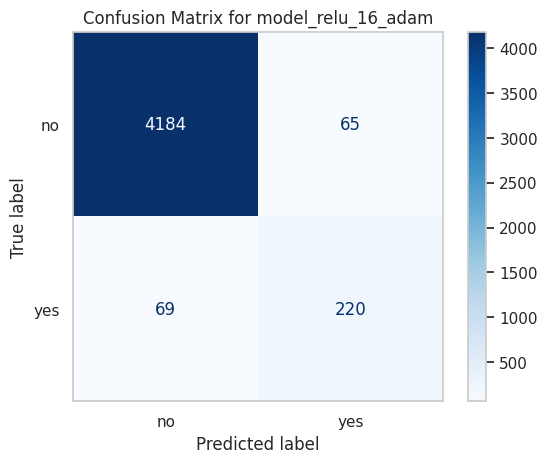

Test AUC for model_relu_16_adam: 0.99


Training model_relu_16_rmsprop...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6868 - loss: 0.6040 - precision_33: 0.1130 - recall_33: 0.4337 - val_accuracy: 0.9507 - val_loss: 0.2185 - val_precision_33: 0.7889 - val_recall_33: 0.3074
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9529 - loss: 0.1735 - precision_33: 0.6470 - recall_33: 0.5177 - val_accuracy: 0.9617 - val_loss: 0.1059 - val_precision_33: 0.8833 - val_recall_33: 0.4589
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9642 - loss: 0.1004 - precision_33: 0.7567 - recall_33: 0.6328 - val_accuracy: 0.9691 - val_loss: 0.0823 - val_precision_33: 0.8251 - val_recall_33: 0.6537
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9672 - loss: 0.0858 - precision_33: 0.7524 - recall_33: 0.6772 - val_accuracy: 0.9722 - val_loss: 0.0810 - val_precision_33: 0.8611 - val_recall_33: 0.6710
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

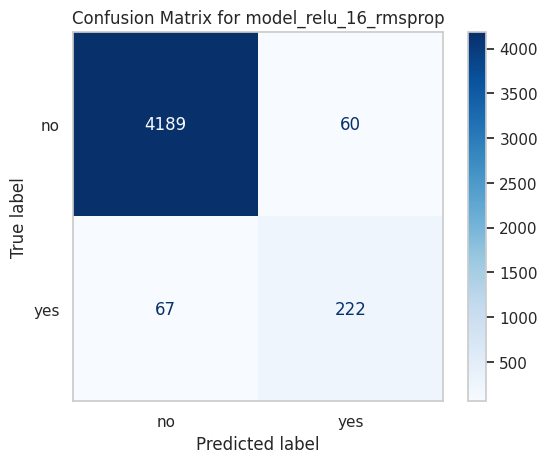

Test AUC for model_relu_16_rmsprop: 0.98


Training model_tanh_16_adam...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7538 - loss: 0.6065 - precision_34: 0.1983 - recall_34: 0.7938 - val_accuracy: 0.9680 - val_loss: 0.1988 - val_precision_34: 0.7778 - val_recall_34: 0.6970
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9638 - loss: 0.1866 - precision_34: 0.7078 - recall_34: 0.7637 - val_accuracy: 0.9713 - val_loss: 0.1001 - val_precision_34: 0.8629 - val_recall_34: 0.6537
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9707 - loss: 0.1008 - precision_34: 0.7842 - recall_34: 0.7254 - val_accuracy: 0.9705 - val_loss: 0.0831 - val_precision_34: 0.8039 - val_recall_34: 0.7100
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9693 - loss: 0.0865 - precision_34: 0.7862 - recall_34: 0.7315 - val_accuracy: 0.9711 - val_loss: 0.0774 - val_precision_34: 0.8214 - val_recall_34: 0.6970
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

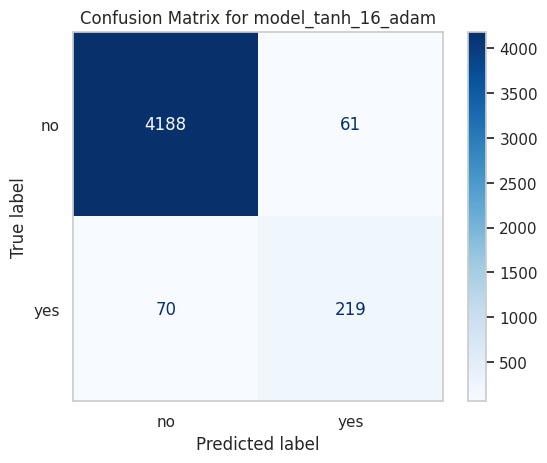

Test AUC for model_tanh_16_adam: 0.99


Training model_tanh_16_rmsprop...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7735 - loss: 0.5539 - precision_35: 0.2183 - recall_35: 0.8094 - val_accuracy: 0.9697 - val_loss: 0.1644 - val_precision_35: 0.8538 - val_recall_35: 0.6320
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9692 - loss: 0.1394 - precision_35: 0.7588 - recall_35: 0.7317 - val_accuracy: 0.9691 - val_loss: 0.0856 - val_precision_35: 0.8251 - val_recall_35: 0.6537
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9702 - loss: 0.0864 - precision_35: 0.7849 - recall_35: 0.6971 - val_accuracy: 0.9702 - val_loss: 0.0799 - val_precision_35: 0.7943 - val_recall_35: 0.7186
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9737 - loss: 0.0742 - precision_35: 0.8067 - recall_35: 0.7707 - val_accuracy: 0.9719 - val_loss: 0.0786 - val_precision_35: 0.7972 - val_recall_35: 0.7489
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

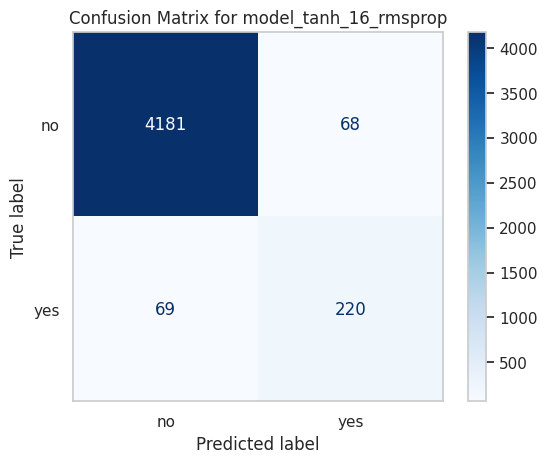

Test AUC for model_tanh_16_rmsprop: 0.98


Training model_relu_32_adam...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7996 - loss: 0.5402 - precision_36: 0.2353 - recall_36: 0.7765 - val_accuracy: 0.9639 - val_loss: 0.1715 - val_precision_36: 0.8968 - val_recall_36: 0.4892
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9641 - loss: 0.1467 - precision_36: 0.7193 - recall_36: 0.6874 - val_accuracy: 0.9702 - val_loss: 0.0982 - val_precision_36: 0.8596 - val_recall_36: 0.6364
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9696 - loss: 0.0930 - precision_36: 0.7719 - recall_36: 0.6934 - val_accuracy: 0.9716 - val_loss: 0.0896 - val_precision_36: 0.8333 - val_recall_36: 0.6926
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9692 - loss: 0.0832 - precision_36: 0.7740 - recall_36: 0.7202 - val_accuracy: 0.9738 - val_loss: 0.0812 - val_precision_36: 0.8469 - val_recall_36: 0.7186
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

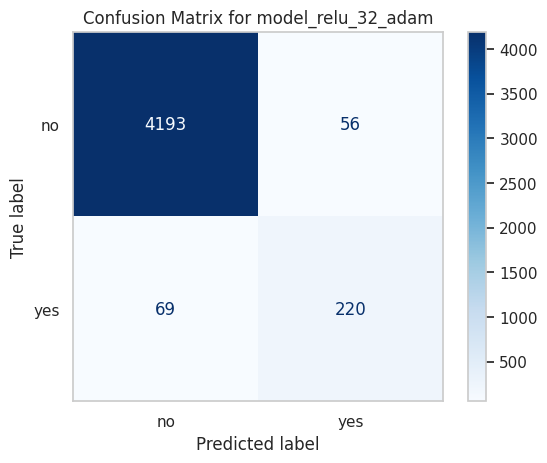

Test AUC for model_relu_32_adam: 0.99


Training model_relu_32_rmsprop...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7854 - loss: 0.5231 - precision_37: 0.2039 - recall_37: 0.6705 - val_accuracy: 0.9650 - val_loss: 0.1372 - val_precision_37: 0.9062 - val_recall_37: 0.5022
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9642 - loss: 0.1175 - precision_37: 0.7603 - recall_37: 0.6473 - val_accuracy: 0.9689 - val_loss: 0.0885 - val_precision_37: 0.8782 - val_recall_37: 0.5931
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9672 - loss: 0.0916 - precision_37: 0.7731 - recall_37: 0.6949 - val_accuracy: 0.9725 - val_loss: 0.0812 - val_precision_37: 0.8359 - val_recall_37: 0.7056
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9686 - loss: 0.0791 - precision_37: 0.7827 - recall_37: 0.7071 - val_accuracy: 0.9727 - val_loss: 0.0827 - val_precision_37: 0.8548 - val_recall_37: 0.6883
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

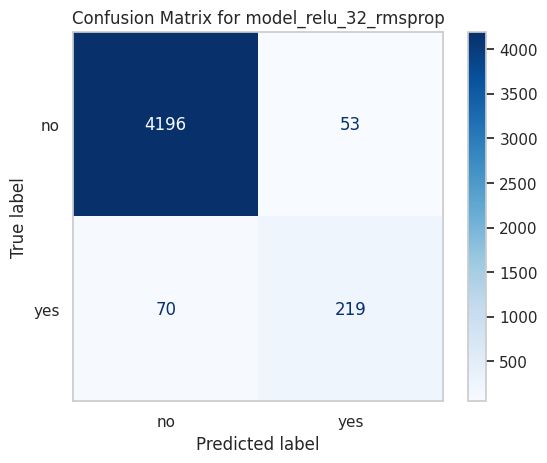

Test AUC for model_relu_32_rmsprop: 0.99


Training model_tanh_32_adam...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7927 - loss: 0.5192 - precision_38: 0.2484 - recall_38: 0.8392 - val_accuracy: 0.9697 - val_loss: 0.1478 - val_precision_38: 0.8418 - val_recall_38: 0.6450
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9675 - loss: 0.1315 - precision_38: 0.7551 - recall_38: 0.7457 - val_accuracy: 0.9702 - val_loss: 0.0890 - val_precision_38: 0.8220 - val_recall_38: 0.6797
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9717 - loss: 0.0842 - precision_38: 0.8110 - recall_38: 0.7452 - val_accuracy: 0.9738 - val_loss: 0.0787 - val_precision_38: 0.8400 - val_recall_38: 0.7273
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9683 - loss: 0.0858 - precision_38: 0.7905 - recall_38: 0.7167 - val_accuracy: 0.9727 - val_loss: 0.0821 - val_precision_38: 0.8084 - val_recall_38: 0.7489
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

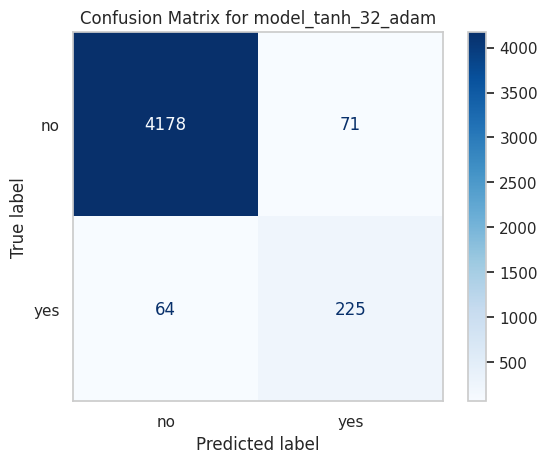

Test AUC for model_tanh_32_adam: 0.98


Training model_tanh_32_rmsprop...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8248 - loss: 0.4936 - precision_39: 0.2616 - recall_39: 0.8106 - val_accuracy: 0.9697 - val_loss: 0.1109 - val_precision_39: 0.8235 - val_recall_39: 0.6667
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9667 - loss: 0.1027 - precision_39: 0.7569 - recall_39: 0.7065 - val_accuracy: 0.9700 - val_loss: 0.0813 - val_precision_39: 0.7850 - val_recall_39: 0.7273
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9678 - loss: 0.0816 - precision_39: 0.7610 - recall_39: 0.7159 - val_accuracy: 0.9708 - val_loss: 0.0777 - val_precision_39: 0.7990 - val_recall_39: 0.7229
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9716 - loss: 0.0722 - precision_39: 0.7854 - recall_39: 0.7421 - val_accuracy: 0.9713 - val_loss: 0.0751 - val_precision_39: 0.8009 - val_recall_39: 0.7316
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

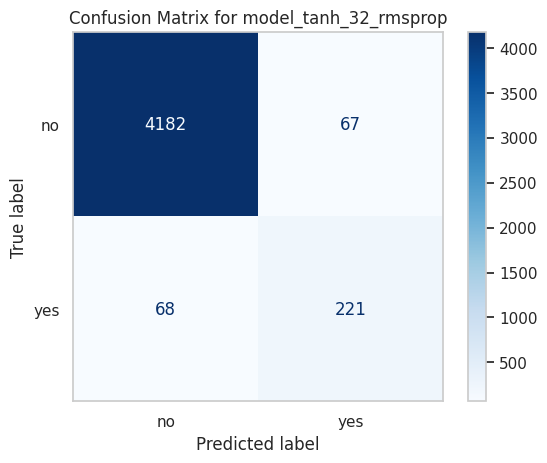

Test AUC for model_tanh_32_rmsprop: 0.98


,model_name,train_accuracy,test_accuracy,test_loss,F1_score,precision,recall,AUC
0,model_relu_16_adam,0.9716,0.9705,0.0709,0.9704,0.9703,0.9705,0.9852
1,model_relu_16_rmsprop,0.9720,0.9720,0.0697,0.9719,0.9717,0.9720,0.9848
2,model_tanh_16_adam,0.9720,0.9711,0.0696,0.9709,0.9707,0.9711,0.9859
3,model_tanh_16_rmsprop,0.9720,0.9698,0.0715,0.9698,0.9698,0.9698,0.9843
4,model_relu_32_adam,0.9724,0.9725,0.0702,0.9722,0.9719,0.9725,0.9856
5,model_relu_32_rmsprop,0.9719,0.9729,0.0695,0.9725,0.9722,0.9729,0.9852
6,model_tanh_32_adam,0.9727,0.9703,0.0725,0.9704,0.9706,0.9703,0.9843
7,model_tanh_32_rmsprop,0.9719,0.9703,0.0711,0.9702,0.9702,0.9703,0.9839


In [ ]:
# List of activation functions
activation_functions = ['relu', 'tanh']

results_list = []

random_seed = seed

def create_model(hidden_neurons, activation, optimizer, loss='binary_crossentropy', metrics=None, l2_reg=None, dropout_rate=None, learning_rate=None):
    model = models.Sequential([
        layers.Input(shape=(X_train_f_scaled.shape[1],)),

        # first hidden layer
        layers.Dense(hidden_neurons, activation=activation),
        layers.BatchNormalization(),

        # second hidden layer
        layers.Dense(hidden_neurons, activation=activation),
        layers.BatchNormalization(),

        # output layer
        layers.Dense(1, activation='sigmoid')
    ])

    if metrics is None:
        metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

#************** Parameters for model training and tuning **********************
hidden_layers_neurons = [16, 32]
activation_functions = ['relu', 'tanh']
optimizers = ['adam', 'rmsprop']

model_histories = {}

# Looping over each combination of hidden layers, activation functions, and optimizers
for hidden_neurons in hidden_layers_neurons:
    for activation in activation_functions:
        for optimizer in optimizers:
            model_name = f"model_{activation}_{hidden_neurons}_{optimizer}"
            print(f"\n\n{'='*50}\nTraining {model_name}...\n{'='*50}\n")

# Create an EarlyStopping callback
            early_stopping_callback = keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                min_delta=0,
                restore_best_weights=True,
            )

#************** Creating the model ******************
            model = create_model(hidden_neurons=hidden_neurons,
                                 activation=activation,
                                 optimizer=optimizer,
                                 learning_rate=0.001,
                                 l2_reg=0.01, dropout_rate=0.2
            )

#************** Fitting the model ******************
            model_history = model.fit(X_train_f_scaled, y_train,
                                      epochs=100,
                                      batch_size=64,
                                      validation_data=(X_val_f_scaled, y_val),
                                      callbacks=[early_stopping_callback],
                                      verbose=1)

            model_histories[model_name] = model_history
            print(f"\n{model_name} has been trained.\n")

            epochs_trained = len(model_history.history['loss'])
            print(f"Training stopped after {epochs_trained} epochs due to early stopping.\n")

            best_train_loss = min(model_history.history['loss'])
            best_val_loss = min(model_history.history['val_loss'])
            print(f"Best Training Loss: {best_train_loss:.4f}")
            print(f"Best Validation Loss: {best_val_loss:.4f}")

#************** Making predictions on the test set (probabilities) ************
            y_test_pred = model.predict(X_test_f_scaled)
            y_test_pred_classes = (y_test_pred > 0.5).astype("int32")

#************** Model evaluation *****************
            test_accuracy = accuracy_score(y_test, y_test_pred_classes)
            print(f"{model_name} Test Accuracy: {test_accuracy:.4f}\n")
            print(classification_report(y_test, y_test_pred_classes))

#************** Confusion Matrix *****************
            cm = confusion_matrix(y_test, y_test_pred_classes)
            cfmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no", "yes"])

            plt.figure(figsize=(4, 2))
            cfmd.plot(cmap='Blues')
            plt.grid(False)
            plt.title(f"Confusion Matrix for {model_name}")
            plt.show()

#************** ROC and AUC *****************
            fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
            roc_auc = roc_auc_score(y_test, y_test_pred)
            print(f"Test AUC for {model_name}: {roc_auc:.2f}")

#************** Training accuracy and loss *****************
            train_loss = model_history.history['loss'][-1]
            train_accuracy = model_history.history['accuracy'][-1]

            test_loss = model.evaluate(X_test_f_scaled, y_test, verbose=0)[0]

# F1 Score, precision, recall
            f1_score = classification_report(y_test, y_test_pred_classes, output_dict=True)['weighted avg']['f1-score']
            precision = classification_report(y_test, y_test_pred_classes, output_dict=True)['weighted avg']['precision']
            recall = classification_report(y_test, y_test_pred_classes, output_dict=True)['weighted avg']['recall']

            results_list.append({
                "model_name": model_name,
                "train_accuracy": train_accuracy,
                "test_accuracy": test_accuracy,
                "test_loss": test_loss,
                "F1_score": f1_score,
                "precision": precision,
                "recall": recall,
                "AUC": roc_auc
            })

summary_df = pd.DataFrame(results_list)
summary_df = summary_df.round(4)
summary_df

**💡Plotting Models loss performance for comparison**

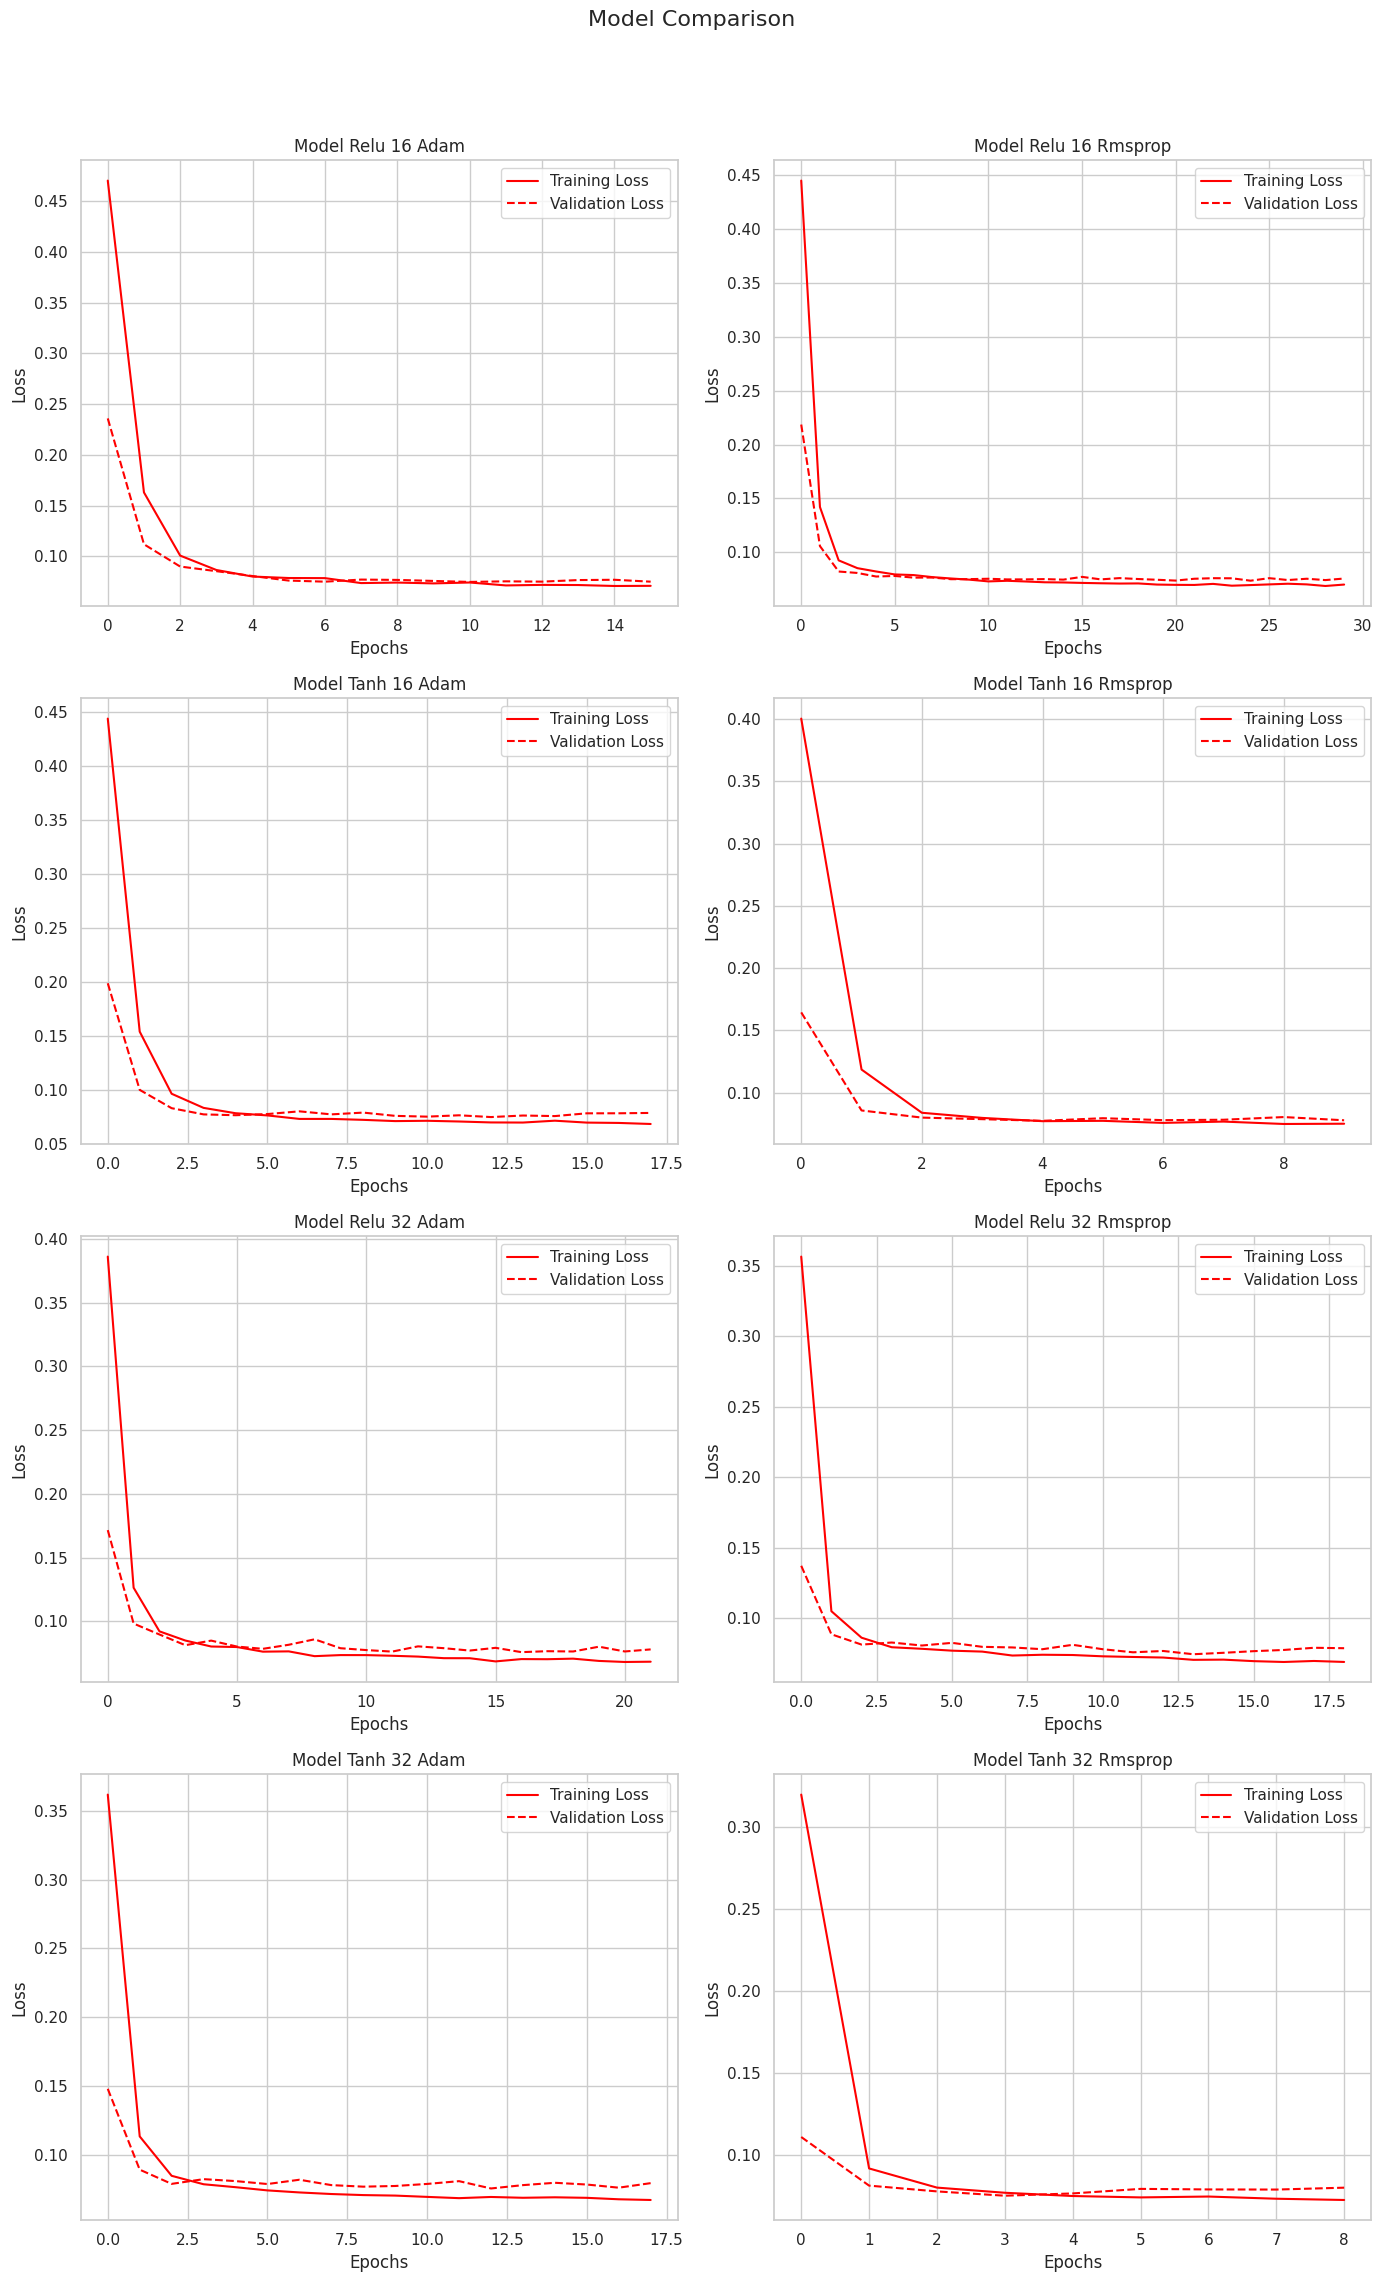

In [ ]:
def plot_model_history(ax, history, title):
    ax.plot(history.history['loss'], label='Training Loss', color='red')
    ax.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

num_models = len(model_histories)
num_cols = 2
num_rows = (num_models + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 6 * num_rows))
fig.suptitle('Model Comparison', fontsize=16)

axs = axs.flatten()

for i, (model_name, history) in enumerate(model_histories.items()):
    plot_model_history(axs[i], history, model_name.replace('_', ' ').title())

for j in range(i + 1, num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Models results summary table**

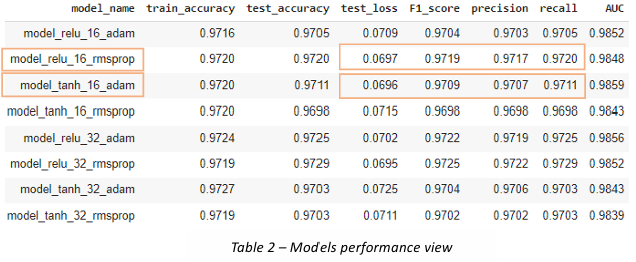

###🔍 The results vary between model, however two models (ReLU 16nn Rmsprop and Tanh 16nn Adam) outperform others, showing improved loss, F1, precision, and recall on the test set compared to the baseline model. The loss curves indicate better alignment between training and validation, suggesting these are well-balanced models.

##**XGBoost Model**

### 💡 Testing now predictions from XGBoost Model. Starting with a baseline model with early stopping.

In [ ]:
# XGBoost Classifier
xgb_model = XGBClassifier(objective='binary:logistic',    # For binary classification
                eval_metric = 'logloss',
                early_stopping_rounds=50,                 # Early stopping for overfitting
                random_state=seed
)

In [ ]:
random_seed=seed

# Fitting the model with evaluation metric (logloss) for train and test
xgb_model.fit(X_f_train, y_train, eval_set=[(X_f_train, y_train), (X_f_test, y_test)], verbose=1)

[0]	validation_0-logloss:0.18289	validation_1-logloss:0.18389
[1]	validation_0-logloss:0.14559	validation_1-logloss:0.14769
[2]	validation_0-logloss:0.12086	validation_1-logloss:0.12415
[3]	validation_0-logloss:0.10346	validation_1-logloss:0.10781
[4]	validation_0-logloss:0.09120	validation_1-logloss:0.09644
[5]	validation_0-logloss:0.08217	validation_1-logloss:0.08873
[6]	validation_0-logloss:0.07568	validation_1-logloss:0.08349
[7]	validation_0-logloss:0.07087	validation_1-logloss:0.07953
[8]	validation_0-logloss:0.06694	validation_1-logloss:0.07687
[9]	validation_0-logloss:0.06385	validation_1-logloss:0.07505
[10]	validation_0-logloss:0.06176	validation_1-logloss:0.07369
[11]	validation_0-logloss:0.06007	validation_1-logloss:0.07299
[12]	validation_0-logloss:0.05831	validation_1-logloss:0.07214
[13]	validation_0-logloss:0.05698	validation_1-logloss:0.07131
[14]	validation_0-logloss:0.05542	validation_1-logloss:0.07087
[15]	validation_0-logloss:0.05454	validation_1-logloss:0.07065
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

XGBoost Model Test Accuracy:  0.9724548259144998
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      4249
         1.0       0.80      0.76      0.78       289

    accuracy                           0.97      4538
   macro avg       0.89      0.87      0.88      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

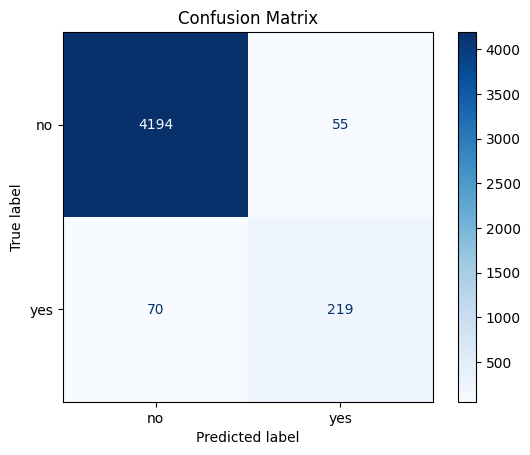

,model_name,train_accuracy,test_accuracy,train_loss,test_loss,F1_score,precision,recall,AUC
0,xgb_model,0.9787,0.9725,0.0339,0.0761,0.9721,0.9718,0.9725,0.8724


In [ ]:
random_seed=seed
model_name = "xgb_model"

results_list = []


# ***************************** Predictions ******************************
train_pred = xgb_model.predict(X_f_train)
test_pred = xgb_model.predict(X_f_test)

# ***************************** Train and Test evaluations *****************
results = xgb_model.evals_result()
train_loss = results['validation_0']['logloss'][-1]
test_loss = results['validation_1']['logloss'][-1]

train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

f1_test = f1_score(y_test, test_pred, average='weighted')   # Weighted F1 score for test set
precision = classification_report(y_test, test_pred, output_dict=True)['weighted avg']['precision']
recall = classification_report(y_test, test_pred, output_dict=True)['weighted avg']['recall']

auc_test = roc_auc_score(y_test, test_pred)

print("XGBoost Model Test Accuracy: ", test_accuracy)
print(classification_report(y_test, test_pred))

#****************************** Confusion Matrix and Plot *********************
cm = confusion_matrix(y_test, test_pred)
cfmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no","yes"])
plt.figure(figsize=(4, 2))
cfmd.plot(cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()

results_list.append({
"model_name": model_name,
"train_accuracy": train_accuracy,
"test_accuracy": test_accuracy,
"train_loss": train_loss,
"test_loss": test_loss,
"F1_score": f1_test,
"precision": precision,
"recall": recall,
"AUC": auc_test
            })
summary_df = pd.DataFrame(results_list)
summary_df = summary_df.round(4)

summary_df

###🔍  The model shows strong recall (97%), precision, and F1 score, though some overfitting is observed between train and test loss.  

**💡 Hyperparameter tuning** via grid search is used to reduce loss and overfitting by testing different combinations of **learning rates (0.1, 0.01)**, **estimators (100, 500)**, and **max depth (4, 8)**.

### **Hyperparameters tuning**

###**Initiating the models**

In [ ]:
#************************** Defining the parameters *************************
learning_rate = [0.1, 0.01]
n_estimators = [100, 500]
max_depth = [4, 8]

random_state=seed

model_counter = 1

xgb_models = {}

# Nested loops for manual grid search
for lr in learning_rate:
    for n_est in n_estimators:
        for depth in max_depth:
            model_name = f"xgbmodel_{lr}_{n_est}_{depth}"
            print(f"\n\n{'='*50}\nTraining {model_name}...\n{'='*50}\n")
            xgb_models[model_name] = XGBClassifier(
                objective='binary:logistic',    # For binary classification
                eval_metric = 'logloss',
                learning_rate=lr,
                n_estimators=n_est,             # Number of trees
                max_depth=depth,                # Maximum depth of each tree
                early_stopping_rounds=50,
                random_state=seed
            )
            print(f"{model_name} created with learning_rate={lr}, n_estimators={n_est}, max_depth={depth}")
            model_counter += 1



Training xgbmodel_0.1_100_4...

xgbmodel_0.1_100_4 created with learning_rate=0.1, n_estimators=100, max_depth=4


Training xgbmodel_0.1_100_8...

xgbmodel_0.1_100_8 created with learning_rate=0.1, n_estimators=100, max_depth=8


Training xgbmodel_0.1_500_4...

xgbmodel_0.1_500_4 created with learning_rate=0.1, n_estimators=500, max_depth=4


Training xgbmodel_0.1_500_8...

xgbmodel_0.1_500_8 created with learning_rate=0.1, n_estimators=500, max_depth=8


Training xgbmodel_0.01_100_4...

xgbmodel_0.01_100_4 created with learning_rate=0.01, n_estimators=100, max_depth=4


Training xgbmodel_0.01_100_8...

xgbmodel_0.01_100_8 created with learning_rate=0.01, n_estimators=100, max_depth=8


Training xgbmodel_0.01_500_4...

xgbmodel_0.01_500_4 created with learning_rate=0.01, n_estimators=500, max_depth=4


Training xgbmodel_0.01_500_8...

xgbmodel_0.01_500_8 created with learning_rate=0.01, n_estimators=500, max_depth=8


###**Fitting the models**

In [ ]:
random_state=seed

model_histories = {}

# Loop over each model in the dictionary
for model_name, model in xgb_models.items():
    print(f"Training {model_name}...")

    model.fit(X_f_train, y_train, eval_set=[(X_f_train, y_train), (X_f_test, y_test)], verbose=0)
    print(f"{model_name} has been trained.\n")

Training xgbmodel_0.1_100_4...
xgbmodel_0.1_100_4 has been trained.

Training xgbmodel_0.1_100_8...
xgbmodel_0.1_100_8 has been trained.

Training xgbmodel_0.1_500_4...
xgbmodel_0.1_500_4 has been trained.

Training xgbmodel_0.1_500_8...
xgbmodel_0.1_500_8 has been trained.

Training xgbmodel_0.01_100_4...
xgbmodel_0.01_100_4 has been trained.

Training xgbmodel_0.01_100_8...
xgbmodel_0.01_100_8 has been trained.

Training xgbmodel_0.01_500_4...
xgbmodel_0.01_500_4 has been trained.

Training xgbmodel_0.01_500_8...
xgbmodel_0.01_500_8 has been trained.



###**Model evaluation**



Evaluating xgbmodel_0.1_100_4...

xgbmodel_0.1_100_4 Test Accuracy: 0.9744
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      4249
         1.0       0.83      0.76      0.79       289

    accuracy                           0.97      4538
   macro avg       0.91      0.87      0.89      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

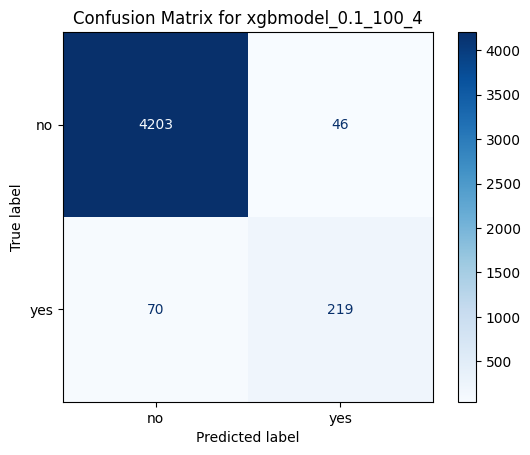



Evaluating xgbmodel_0.1_100_8...

xgbmodel_0.1_100_8 Test Accuracy: 0.9714
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      4249
         1.0       0.79      0.74      0.77       289

    accuracy                           0.97      4538
   macro avg       0.89      0.87      0.88      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

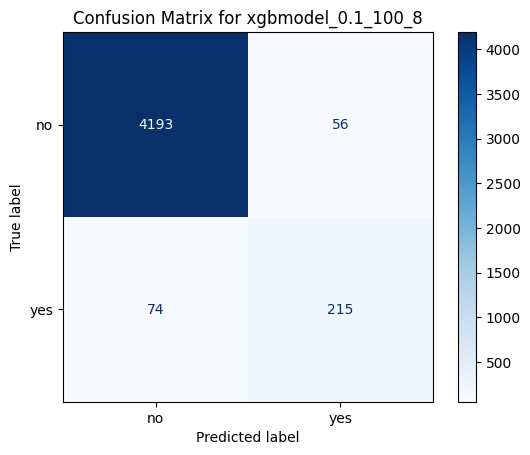



Evaluating xgbmodel_0.1_500_4...

xgbmodel_0.1_500_4 Test Accuracy: 0.9744
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      4249
         1.0       0.83      0.76      0.79       289

    accuracy                           0.97      4538
   macro avg       0.91      0.87      0.89      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

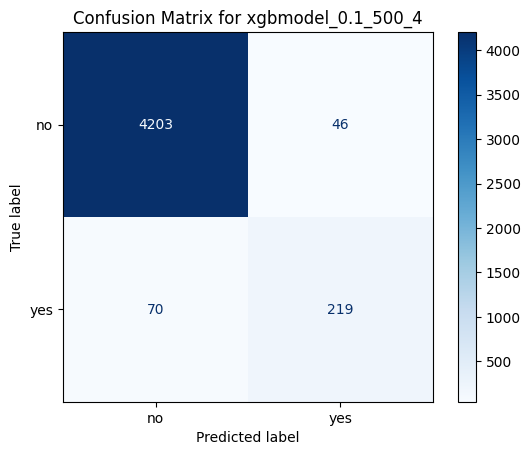



Evaluating xgbmodel_0.1_500_8...

xgbmodel_0.1_500_8 Test Accuracy: 0.9714
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      4249
         1.0       0.79      0.74      0.77       289

    accuracy                           0.97      4538
   macro avg       0.89      0.87      0.88      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

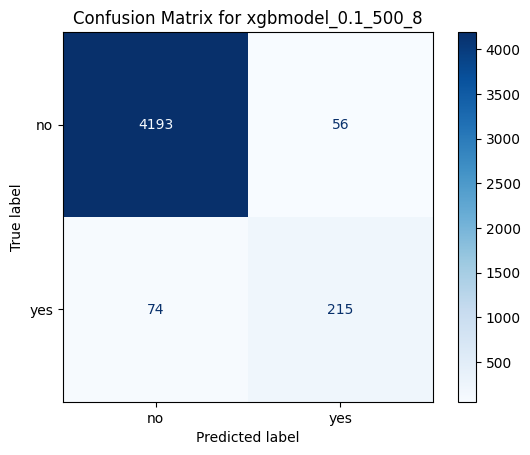



Evaluating xgbmodel_0.01_100_4...

xgbmodel_0.01_100_4 Test Accuracy: 0.9645
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      4249
         1.0       0.88      0.51      0.65       289

    accuracy                           0.96      4538
   macro avg       0.92      0.75      0.81      4538
weighted avg       0.96      0.96      0.96      4538



<Figure size 400x200 with 0 Axes>

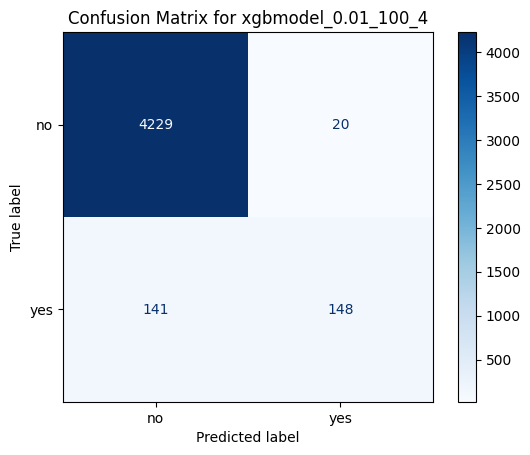



Evaluating xgbmodel_0.01_100_8...

xgbmodel_0.01_100_8 Test Accuracy: 0.9689
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      4249
         1.0       0.89      0.59      0.71       289

    accuracy                           0.97      4538
   macro avg       0.93      0.79      0.85      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

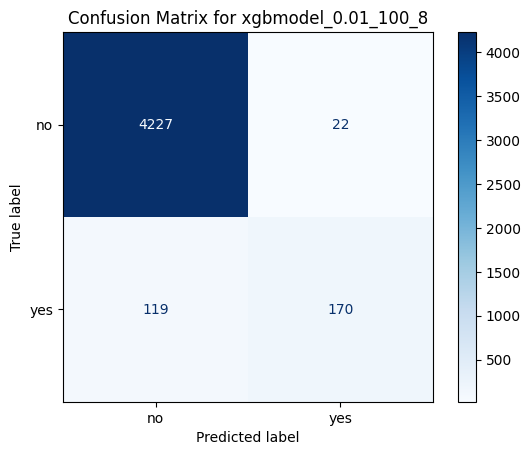



Evaluating xgbmodel_0.01_500_4...

xgbmodel_0.01_500_4 Test Accuracy: 0.9725
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      4249
         1.0       0.82      0.73      0.77       289

    accuracy                           0.97      4538
   macro avg       0.90      0.86      0.88      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

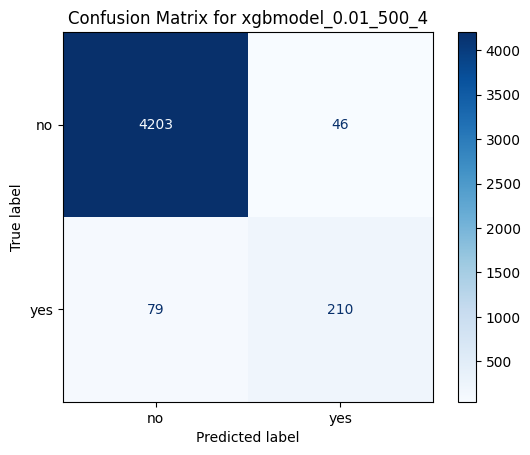



Evaluating xgbmodel_0.01_500_8...

xgbmodel_0.01_500_8 Test Accuracy: 0.9725
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      4249
         1.0       0.80      0.75      0.78       289

    accuracy                           0.97      4538
   macro avg       0.89      0.87      0.88      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

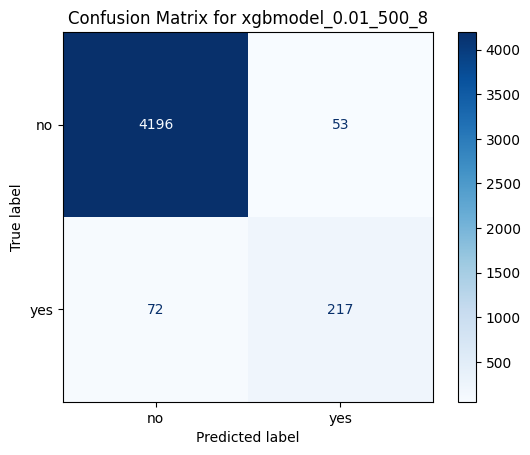

,model_name,train_accuracy,test_accuracy,train_loss,test_loss,F1_score,precision,recall,AUC
0,xgbmodel_0.1_100_4,0.9753,0.9744,0.0582,0.0692,0.9739,0.9736,0.9744,0.8735
1,xgbmodel_0.1_100_8,0.9837,0.9714,0.0371,0.0732,0.9709,0.9706,0.9714,0.8654
2,xgbmodel_0.1_500_4,0.9753,0.9744,0.0549,0.0691,0.9739,0.9736,0.9744,0.8735
3,xgbmodel_0.1_500_8,0.9837,0.9714,0.0367,0.0733,0.9709,0.9706,0.9714,0.8654
4,xgbmodel_0.01_100_4,0.9663,0.9645,0.1246,0.1259,0.9601,0.9622,0.9645,0.7537
5,xgbmodel_0.01_100_8,0.9722,0.9689,0.1171,0.1229,0.9660,0.9671,0.9689,0.7915
6,xgbmodel_0.01_500_4,0.9737,0.9725,0.0650,0.0713,0.9717,0.9713,0.9725,0.8579
7,xgbmodel_0.01_500_8,0.9839,0.9725,0.0473,0.0718,0.9720,0.9717,0.9725,0.8692


In [ ]:
random_state=seed

results_list = []

for model_name, model in xgb_models.items():
    print(f"\n\n{'='*50}\nEvaluating {model_name}...\n{'='*50}\n")

    # ******************************** Predictions *****************************
    train_pred = model.predict(X_f_train)
    test_pred = model.predict(X_f_test)

    # ***************************** Train and Test evaluations *****************
    results = model.evals_result()
    train_loss = results['validation_0']['logloss'][-1]
    test_loss = results['validation_1']['logloss'][-1]

    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)

    auc_test = roc_auc_score(y_test, test_pred)

    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test, test_pred))

    f1_test = f1_score(y_test, test_pred, average='weighted')  # Weighted F1 score for test set
    precision = classification_report(y_test, test_pred, output_dict=True)['weighted avg']['precision']
    recall = classification_report(y_test, test_pred, output_dict=True)['weighted avg']['recall']

#****************************** Confusion Matrix and Plot *********************
    cm = confusion_matrix(y_test, test_pred)
    cfmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no", "yes"])
    plt.figure(figsize=(4, 2))
    cfmd.plot(cmap='Blues')
    plt.grid(False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    results_list.append({
        "model_name": model_name,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "F1_score": f1_test,
        "precision": precision,
        "recall": recall,
        "AUC": auc_test
    })

summary_df = pd.DataFrame(results_list)
summary_df = summary_df.round(4)

summary_df

🔍 **xgb_model_1** has already improved compared to baseline model. It also seems to perform well on fitting and generalisation.

🔍 **xgb_model_5** and **xgb_model_6**, both with low learning rate and estimators, have the worse performance.

🔍 The models with **max_depth=8** highly overfit when compared to models with a lower depth of 4.

**Key insights** from models results include:  

- Lower max depth generally improves model fitting, while higher max depth leads to overfitting due to its complexity;

- Low learning rate and low estimators (models 5 0.01_100_4,  6 0.01_100_8) result in higher loss and underfitting due to slow learning and insufficient complexity.

#**Part 2.** Models with 2 additional variables

### 💡 In this part of the work I want to add two more variables to test if they help improve predictions and models results. The variables are **ContactHours** and **AttendancePercentage**. The aim is to establish wether this  additional information helps improve our predictions.

##**Neural Network**




Training model_relu_16_adam...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8100 - loss: 0.5589 - precision_8: 0.2417 - recall_8: 0.8702 - val_accuracy: 0.9645 - val_loss: 0.2178 - val_precision_8: 0.6861 - val_recall_8: 0.8139
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9630 - loss: 0.1817 - precision_8: 0.6889 - recall_8: 0.7926 - val_accuracy: 0.9766 - val_loss: 0.0874 - val_precision_8: 0.8650 - val_recall_8: 0.7489
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9721 - loss: 0.0964 - precision_8: 0.8127 - recall_8: 0.7302 - val_accuracy: 0.9769 - val_loss: 0.0725 - val_precision_8: 0.9153 - val_recall_8: 0.7013
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9727 - loss: 0.0760 - precision_8: 0.8256 - recall_8: 0.7447 - val_accuracy: 0.9780 - val_loss: 0.0677 - val_precision_8: 0.8832 - val_recall_8: 0.7532
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9753 - loss: 0.0678 - p

<Figure size 400x200 with 0 Axes>

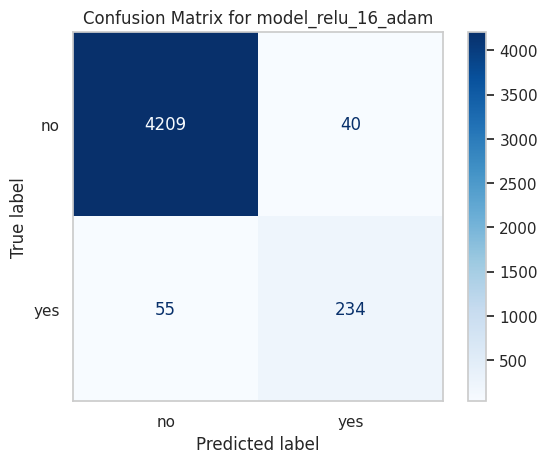

Test AUC for model_relu_16_adam: 0.99


Training model_relu_16_rmsprop...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7400 - loss: 0.5730 - precision_9: 0.1872 - recall_9: 0.7172 - val_accuracy: 0.9725 - val_loss: 0.1727 - val_precision_9: 0.8429 - val_recall_9: 0.6970
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9701 - loss: 0.1470 - precision_9: 0.7740 - recall_9: 0.7454 - val_accuracy: 0.9766 - val_loss: 0.0762 - val_precision_9: 0.9056 - val_recall_9: 0.7056
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9747 - loss: 0.0769 - precision_9: 0.8463 - recall_9: 0.7423 - val_accuracy: 0.9758 - val_loss: 0.0679 - val_precision_9: 0.8629 - val_recall_9: 0.7359
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9749 - loss: 0.0709 - precision_9: 0.8412 - recall_9: 0.7457 - val_accuracy: 0.9744 - val_loss: 0.0684 - val_precision_9: 0.8791 - val_recall_9: 0.6926
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/s

<Figure size 400x200 with 0 Axes>

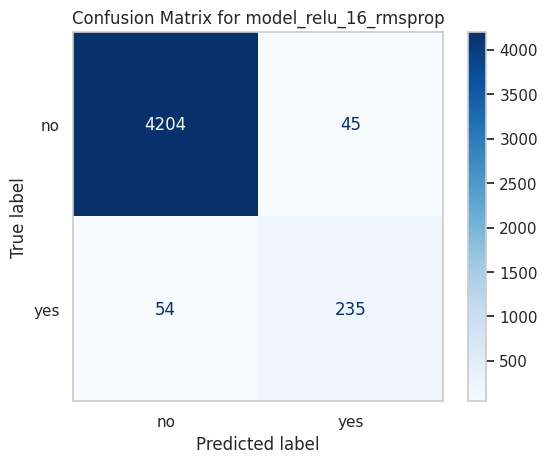

Test AUC for model_relu_16_rmsprop: 0.99


Training model_tanh_16_adam...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7499 - loss: 0.5754 - precision_10: 0.2158 - recall_10: 0.8804 - val_accuracy: 0.9730 - val_loss: 0.2121 - val_precision_10: 0.8037 - val_recall_10: 0.7619
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9683 - loss: 0.1781 - precision_10: 0.7466 - recall_10: 0.7943 - val_accuracy: 0.9758 - val_loss: 0.0905 - val_precision_10: 0.8629 - val_recall_10: 0.7359
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9746 - loss: 0.0913 - precision_10: 0.8339 - recall_10: 0.7448 - val_accuracy: 0.9774 - val_loss: 0.0692 - val_precision_10: 0.8599 - val_recall_10: 0.7706
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9772 - loss: 0.0707 - precision_10: 0.8317 - recall_10: 0.7780 - val_accuracy: 0.9780 - val_loss: 0.0661 - val_precision_10: 0.8683 - val_recall_10: 0.7706
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

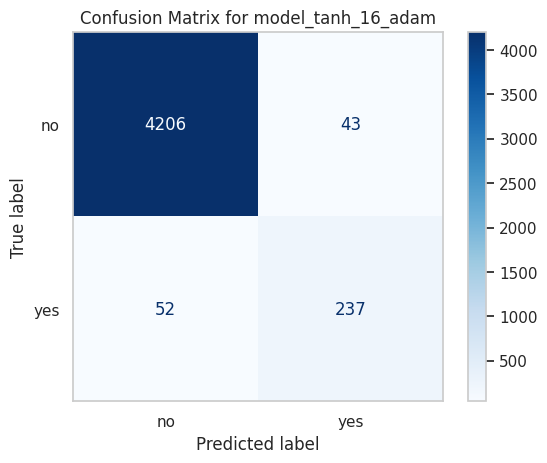

Test AUC for model_tanh_16_adam: 0.99


Training model_tanh_16_rmsprop...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7732 - loss: 0.5750 - precision_11: 0.1908 - recall_11: 0.6681 - val_accuracy: 0.9708 - val_loss: 0.1825 - val_precision_11: 0.8173 - val_recall_11: 0.6970
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9712 - loss: 0.1468 - precision_11: 0.7705 - recall_11: 0.7785 - val_accuracy: 0.9760 - val_loss: 0.0704 - val_precision_11: 0.8913 - val_recall_11: 0.7100
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9726 - loss: 0.0742 - precision_11: 0.8293 - recall_11: 0.7407 - val_accuracy: 0.9763 - val_loss: 0.0639 - val_precision_11: 0.8962 - val_recall_11: 0.7100
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9774 - loss: 0.0617 - precision_11: 0.8523 - recall_11: 0.7818 - val_accuracy: 0.9793 - val_loss: 0.0589 - val_precision_11: 0.8679 - val_recall_11: 0.7965
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

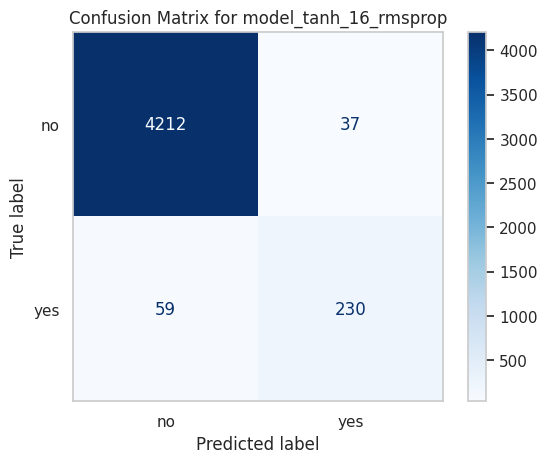

Test AUC for model_tanh_16_rmsprop: 0.99


Training model_relu_32_adam...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7639 - loss: 0.5516 - precision_12: 0.2228 - recall_12: 0.8795 - val_accuracy: 0.9747 - val_loss: 0.1577 - val_precision_12: 0.8601 - val_recall_12: 0.7186
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9691 - loss: 0.1327 - precision_12: 0.7686 - recall_12: 0.7632 - val_accuracy: 0.9760 - val_loss: 0.0799 - val_precision_12: 0.8871 - val_recall_12: 0.7143
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9741 - loss: 0.0781 - precision_12: 0.8409 - recall_12: 0.7328 - val_accuracy: 0.9758 - val_loss: 0.0700 - val_precision_12: 0.8629 - val_recall_12: 0.7359
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9749 - loss: 0.0653 - precision_12: 0.8512 - recall_12: 0.7445 - val_accuracy: 0.9771 - val_loss: 0.0668 - val_precision_12: 0.9022 - val_recall_12: 0.7186
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

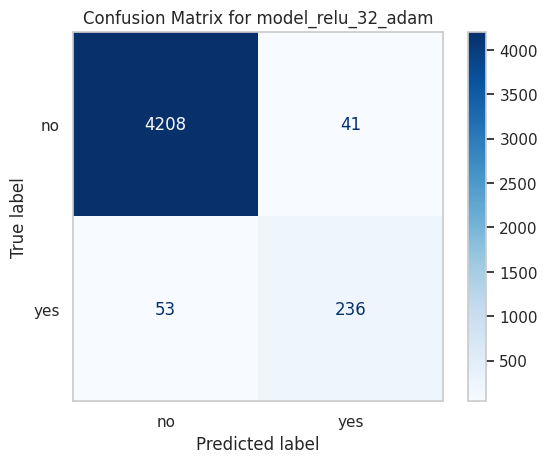

Test AUC for model_relu_32_adam: 0.99


Training model_relu_32_rmsprop...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8139 - loss: 0.5153 - precision_13: 0.2569 - recall_13: 0.7605 - val_accuracy: 0.9722 - val_loss: 0.1209 - val_precision_13: 0.8571 - val_recall_13: 0.6753
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9692 - loss: 0.1048 - precision_13: 0.7898 - recall_13: 0.6980 - val_accuracy: 0.9747 - val_loss: 0.0701 - val_precision_13: 0.8677 - val_recall_13: 0.7100
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9771 - loss: 0.0682 - precision_13: 0.8588 - recall_13: 0.7520 - val_accuracy: 0.9777 - val_loss: 0.0659 - val_precision_13: 0.8906 - val_recall_13: 0.7403
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9773 - loss: 0.0649 - precision_13: 0.8578 - recall_13: 0.7770 - val_accuracy: 0.9774 - val_loss: 0.0633 - val_precision_13: 0.9027 - val_recall_13: 0.7229
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

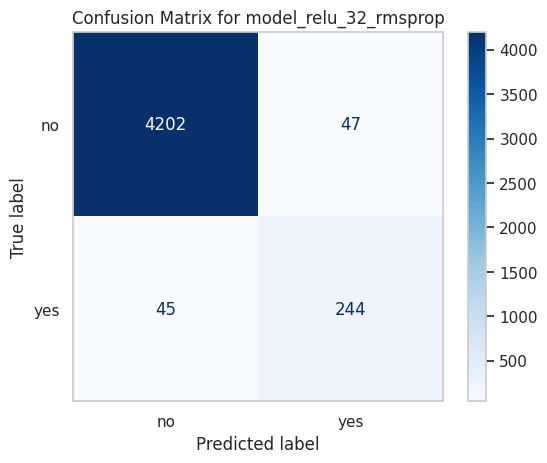

Test AUC for model_relu_32_rmsprop: 0.99


Training model_tanh_32_adam...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7640 - loss: 0.5678 - precision_14: 0.2059 - recall_14: 0.6955 - val_accuracy: 0.9747 - val_loss: 0.1415 - val_precision_14: 0.8424 - val_recall_14: 0.7403
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9702 - loss: 0.1318 - precision_14: 0.7694 - recall_14: 0.7500 - val_accuracy: 0.9771 - val_loss: 0.0737 - val_precision_14: 0.8776 - val_recall_14: 0.7446
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9735 - loss: 0.0815 - precision_14: 0.8243 - recall_14: 0.7603 - val_accuracy: 0.9758 - val_loss: 0.0674 - val_precision_14: 0.8178 - val_recall_14: 0.7965
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9758 - loss: 0.0677 - precision_14: 0.8569 - recall_14: 0.7605 - val_accuracy: 0.9788 - val_loss: 0.0637 - val_precision_14: 0.8598 - val_recall_14: 0.7965
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

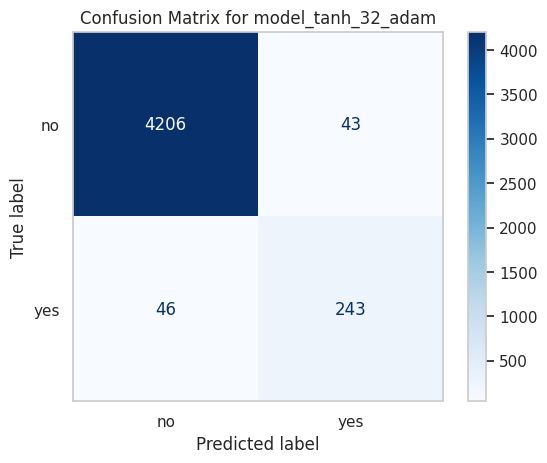

Test AUC for model_tanh_32_adam: 0.99


Training model_tanh_32_rmsprop...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8376 - loss: 0.4698 - precision_15: 0.3031 - recall_15: 0.8343 - val_accuracy: 0.9738 - val_loss: 0.0957 - val_precision_15: 0.8469 - val_recall_15: 0.7186
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9717 - loss: 0.0913 - precision_15: 0.8237 - recall_15: 0.7141 - val_accuracy: 0.9777 - val_loss: 0.0623 - val_precision_15: 0.8505 - val_recall_15: 0.7879
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9751 - loss: 0.0644 - precision_15: 0.8344 - recall_15: 0.7502 - val_accuracy: 0.9782 - val_loss: 0.0638 - val_precision_15: 0.9176 - val_recall_15: 0.7229
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9761 - loss: 0.0591 - precision_15: 0.8401 - recall_15: 0.7447 - val_accuracy: 0.9769 - val_loss: 0.0621 - val_precision_15: 0.8451 - val_recall_15: 0.7792
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

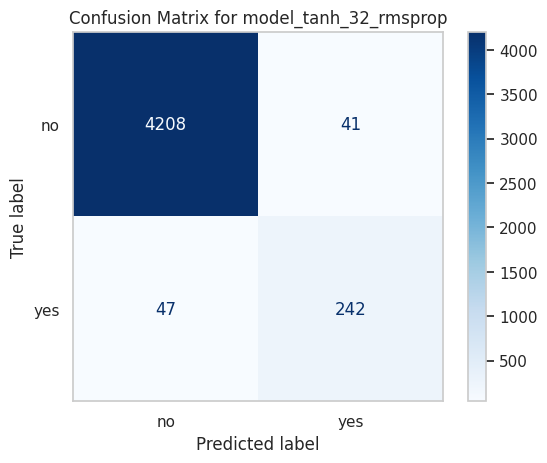

Test AUC for model_tanh_32_rmsprop: 0.99


,model_name,train_accuracy,test_accuracy,test_loss,F1_score,precision,recall,AUC
0,model_relu_16_adam,0.9780,0.9791,0.0535,0.9788,0.9786,0.9791,0.9911
1,model_relu_16_rmsprop,0.9776,0.9782,0.0532,0.9780,0.9779,0.9782,0.9919
2,model_tanh_16_adam,0.9804,0.9791,0.0533,0.9789,0.9788,0.9791,0.9910
3,model_tanh_16_rmsprop,0.9793,0.9788,0.0551,0.9785,0.9782,0.9788,0.9896
4,model_relu_32_adam,0.9808,0.9793,0.0559,0.9791,0.9789,0.9793,0.9902
5,model_relu_32_rmsprop,0.9791,0.9797,0.0538,0.9798,0.9798,0.9797,0.9903
6,model_tanh_32_adam,0.9808,0.9804,0.0513,0.9803,0.9803,0.9804,0.9911
7,model_tanh_32_rmsprop,0.9785,0.9806,0.0527,0.9805,0.9804,0.9806,0.9911


In [ ]:
activation_functions = ['relu', 'tanh']

results_list = []

random_seed = seed

def create_model(hidden_neurons, activation, optimizer, loss='binary_crossentropy', metrics=None, l2_reg=None, dropout_rate=None, learning_rate=None):
    model = models.Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),

        # first hidden layer
        layers.Dense(hidden_neurons, activation=activation),
        layers.BatchNormalization(),

        # second hidden layer
        layers.Dense(hidden_neurons, activation=activation),
        layers.BatchNormalization(),

        # output layer
        layers.Dense(1, activation='sigmoid')
    ])

    if metrics is None:
        metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

#************** Parameters for model training and tuning **********************
hidden_layers_neurons = [16, 32]
activation_functions = ['relu', 'tanh']
optimizers = ['adam', 'rmsprop']

model_histories = {}

# Looping over each combination of hidden layers, activation functions, and optimizers
for hidden_neurons in hidden_layers_neurons:
    for activation in activation_functions:
        for optimizer in optimizers:
            model_name = f"model_{activation}_{hidden_neurons}_{optimizer}"
            print(f"\n\n{'='*50}\nTraining {model_name}...\n{'='*50}\n")

            early_stopping_callback = keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                min_delta=0,
                restore_best_weights=True,
            )

#************************** Creating the model ********************************
            model = create_model(hidden_neurons=hidden_neurons,
                                 activation=activation,
                                 optimizer=optimizer,
                                 learning_rate=0.001,
                                 l2_reg=0.01, dropout_rate=0.2,
            )

#************************** Fitting the model  ********************************
            model_history = model.fit(X_train_scaled, y_train,
                                      epochs=100,
                                      batch_size=64,
                                      validation_data=(X_val_scaled, y_val),
                                      callbacks=[early_stopping_callback],
                                      verbose=1)

            model_histories[model_name] = model_history
            print(f"\n{model_name} has been trained.\n")

            epochs_trained = len(model_history.history['loss'])
            print(f"Training stopped after {epochs_trained} epochs due to early stopping.\n")

            best_train_loss = min(model_history.history['loss'])
            best_val_loss = min(model_history.history['val_loss'])

            print(f"Best Training Loss: {best_train_loss:.4f}")
            print(f"Best Validation Loss: {best_val_loss:.4f}")

#************** Making predictions on the test set (probabilities) ************
            y_test_pred = model.predict(X_test_scaled)
            y_test_pred_classes = (y_test_pred > 0.5).astype("int32")


            test_accuracy = accuracy_score(y_test, y_test_pred_classes)
            print(f"{model_name} Test Accuracy: {test_accuracy:.4f}\n")
            print(classification_report(y_test, y_test_pred_classes))

#************************** Confusion Matrix ********************************
            cm = confusion_matrix(y_test, y_test_pred_classes)
            cfmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no", "yes"])

            plt.figure(figsize=(4, 2))
            cfmd.plot(cmap='Blues')
            plt.grid(False)
            plt.title(f"Confusion Matrix for {model_name}")
            plt.show()

#**************************** ROC and AUC *************************************
            fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
            roc_auc = roc_auc_score(y_test, y_test_pred)
            print(f"Test AUC for {model_name}: {roc_auc:.2f}")

#*************************** Training accuracy and loss ***********************
            train_loss = model_history.history['loss'][-1]
            train_accuracy = model_history.history['accuracy'][-1]


            test_loss = model.evaluate(X_test_scaled, y_test, verbose=0)[0]

            # F1 Score, precision, recall
            f1_score = classification_report(y_test, y_test_pred_classes, output_dict=True)['weighted avg']['f1-score']
            precision = classification_report(y_test, y_test_pred_classes, output_dict=True)['weighted avg']['precision']
            recall = classification_report(y_test, y_test_pred_classes, output_dict=True)['weighted avg']['recall']

            results_list.append({
                "model_name": model_name,
                "train_accuracy": train_accuracy,
                "test_accuracy": test_accuracy,
                "test_loss": test_loss,
                "F1_score": f1_score,
                "precision": precision,
                "recall": recall,
                "AUC": roc_auc
            })

summary_df = pd.DataFrame(results_list)
summary_df = summary_df.round(4)
summary_df


**💡Plotting Models loss performance for comparison**

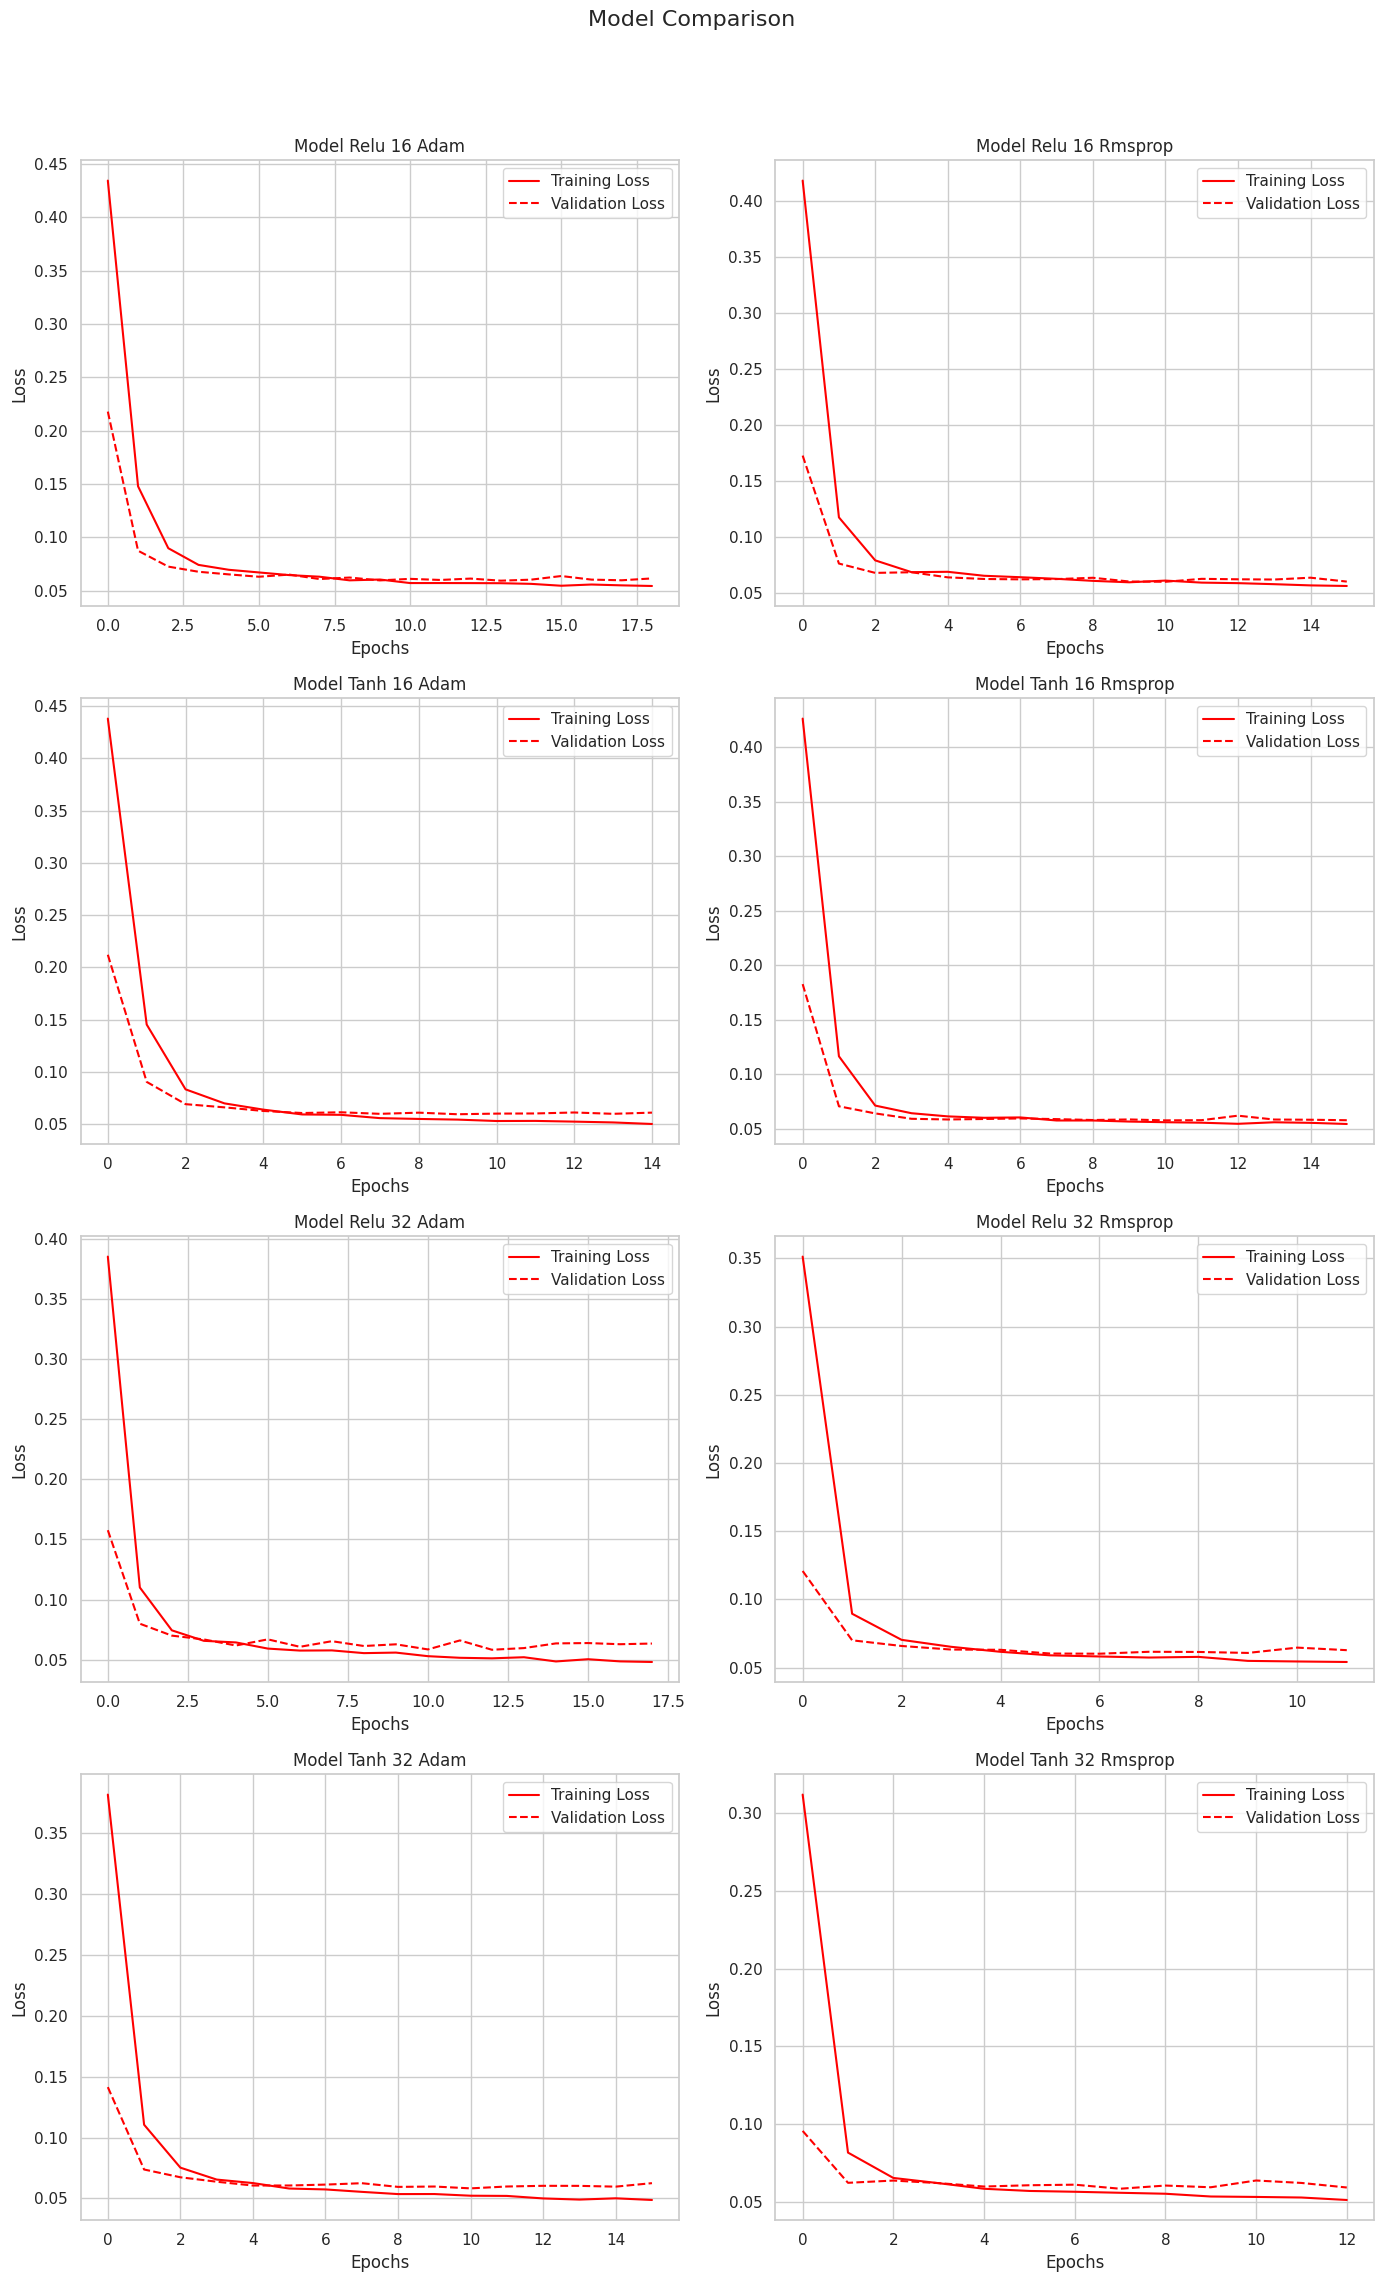

In [ ]:
def plot_model_history(ax, history, title):
    ax.plot(history.history['loss'], label='Training Loss', color='red')
    ax.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

num_models = len(model_histories)
num_cols = 2
num_rows = (num_models + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 6 * num_rows))
fig.suptitle('Model Comparison', fontsize=16)

axs = axs.flatten()

for i, (model_name, history) in enumerate(model_histories.items()):
    plot_model_history(axs[i], history, model_name.replace('_', ' ').title())

for j in range(i + 1, num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

###🔍 Like the models above, **16 neurons model** has a better fitting, with loss curve from validation perfectly fitting with training loss curve. A simpler model that generalise better to unseen data by capturing essential patterns, focussing on the most relevant features.

##**XGBoost Model**

In [ ]:
xgb_model_full = XGBClassifier(
    objective='binary:logistic',
    eval_metric = 'logloss',
    early_stopping_rounds=50,
    random_state=seed
)

In [ ]:
random_seed=seed

xgb_model_full.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

XGBoost Model Test Accuracy:  0.9819303657999119
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4249
         1.0       0.87      0.84      0.86       289

    accuracy                           0.98      4538
   macro avg       0.93      0.92      0.92      4538
weighted avg       0.98      0.98      0.98      4538



<Figure size 400x200 with 0 Axes>

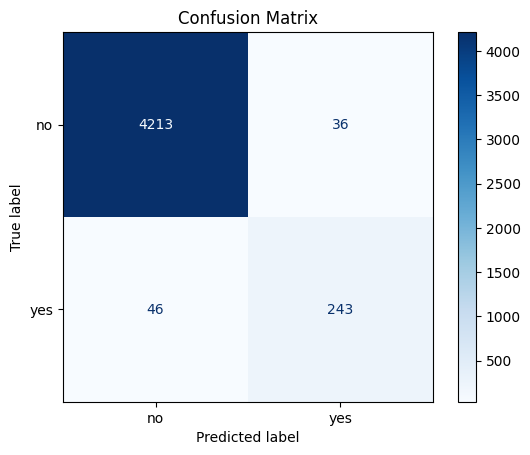

,model_name,train_accuracy,test_accuracy,train_loss,test_loss,F1_score,precision,recall,AUC
0,xgb_model_full,0.9965,0.9819,0.0122,0.0557,0.9818,0.9817,0.9819,0.9162


In [ ]:
random_seed=seed
model_name = "xgb_model_full"

results_list = []

#********************************* Predictions ********************************
train_pred = xgb_model_full.predict(X_train)
test_pred = xgb_model_full.predict(X_test)


#**************************** Train and Test Evaluation ***********************
results = xgb_model_full.evals_result()
train_loss = results['validation_0']['logloss'][-1]
test_loss = results['validation_1']['logloss'][-1]

train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

f1_test = f1_score(y_test, test_pred, average='weighted')
precision = classification_report(y_test, test_pred, output_dict=True)['weighted avg']['precision']
recall = classification_report(y_test, test_pred, output_dict=True)['weighted avg']['recall']

auc_test = roc_auc_score(y_test, test_pred)

print("XGBoost Model Test Accuracy: ", test_accuracy)
print(classification_report(y_test, test_pred))

#**************************** Confusion Matrix and Plot ************************
cm = confusion_matrix(y_test, test_pred)
cfmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no","yes"])
plt.figure(figsize=(4, 2))
cfmd.plot(cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()

results_list.append({
"model_name": model_name,
"train_accuracy": train_accuracy,
"test_accuracy": test_accuracy,
"train_loss": train_loss,
"test_loss": test_loss,
"F1_score": f1_test,
"precision": precision,
"recall": recall,
"AUC": auc_test
            })

summary_df = pd.DataFrame(results_list)
summary_df = summary_df.round(4)

summary_df

### 🔍The model above overall performs well in term of all the metrics, however AUC is not the stronges.

### There is also an over fitting due to slighly significant gap between train and test loss.

### **Hyperparameters tuning**

###**Initiating the models**

In [ ]:
#************************** Defining the parameters *************************
learning_rate = [0.1, 0.01]
n_estimators = [100, 500]
max_depth = [4, 8]

random_state=seed

xgb_models = {}

# Nested loops for manual grid search
for lr in learning_rate:
    for n_est in n_estimators:
        for depth in max_depth:
            model_name = f"xgbmodel_{lr}_{n_est}_{depth}"
            print(f"\n\n{'='*50}\nTraining {model_name}...\n{'='*50}\n")
            xgb_models[model_name] = XGBClassifier(
                objective='binary:logistic',    # For binary classification
                eval_metric = 'logloss',
                learning_rate=lr,
                n_estimators=n_est,             # Number of trees
                max_depth=depth,                # Maximum depth of each tree
                early_stopping_rounds=50,
                random_state=seed
            )
            print(f"{model_name} created with learning_rate={lr}, n_estimators={n_est}, max_depth={depth}")
            model_counter += 1



Training xgbmodel_0.1_100_4...

xgbmodel_0.1_100_4 created with learning_rate=0.1, n_estimators=100, max_depth=4


Training xgbmodel_0.1_100_8...

xgbmodel_0.1_100_8 created with learning_rate=0.1, n_estimators=100, max_depth=8


Training xgbmodel_0.1_500_4...

xgbmodel_0.1_500_4 created with learning_rate=0.1, n_estimators=500, max_depth=4


Training xgbmodel_0.1_500_8...

xgbmodel_0.1_500_8 created with learning_rate=0.1, n_estimators=500, max_depth=8


Training xgbmodel_0.01_100_4...

xgbmodel_0.01_100_4 created with learning_rate=0.01, n_estimators=100, max_depth=4


Training xgbmodel_0.01_100_8...

xgbmodel_0.01_100_8 created with learning_rate=0.01, n_estimators=100, max_depth=8


Training xgbmodel_0.01_500_4...

xgbmodel_0.01_500_4 created with learning_rate=0.01, n_estimators=500, max_depth=4


Training xgbmodel_0.01_500_8...

xgbmodel_0.01_500_8 created with learning_rate=0.01, n_estimators=500, max_depth=8


###**Fitting the models**

In [ ]:
random_state=seed

model_histories = {}

for model_name, model in xgb_models.items():
    print(f"Training {model_name}...")

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0)

    model_histories[model_name] = model.evals_result()

    print(f"{model_name} has been trained.\n")

Training xgbmodel_0.1_100_4...
xgbmodel_0.1_100_4 has been trained.

Training xgbmodel_0.1_100_8...
xgbmodel_0.1_100_8 has been trained.

Training xgbmodel_0.1_500_4...
xgbmodel_0.1_500_4 has been trained.

Training xgbmodel_0.1_500_8...
xgbmodel_0.1_500_8 has been trained.

Training xgbmodel_0.01_100_4...
xgbmodel_0.01_100_4 has been trained.

Training xgbmodel_0.01_100_8...
xgbmodel_0.01_100_8 has been trained.

Training xgbmodel_0.01_500_4...
xgbmodel_0.01_500_4 has been trained.

Training xgbmodel_0.01_500_8...
xgbmodel_0.01_500_8 has been trained.



###**Model evaluation**



Evaluating xgbmodel_0.1_100_4...

xgbmodel_0.1_100_4 Test Accuracy: 0.9797
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4249
         1.0       0.85      0.83      0.84       289

    accuracy                           0.98      4538
   macro avg       0.92      0.91      0.91      4538
weighted avg       0.98      0.98      0.98      4538



<Figure size 400x200 with 0 Axes>

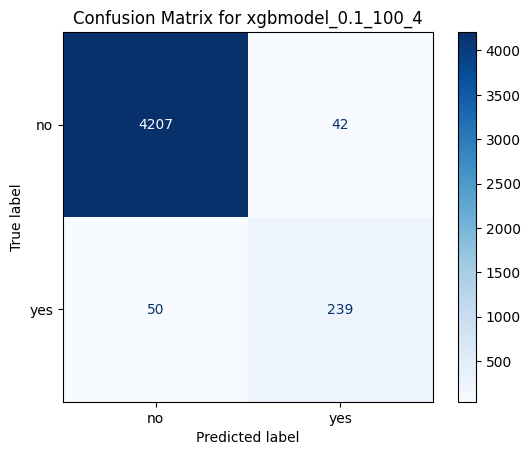



Evaluating xgbmodel_0.1_100_8...

xgbmodel_0.1_100_8 Test Accuracy: 0.9813
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4249
         1.0       0.86      0.84      0.85       289

    accuracy                           0.98      4538
   macro avg       0.93      0.91      0.92      4538
weighted avg       0.98      0.98      0.98      4538



<Figure size 400x200 with 0 Axes>

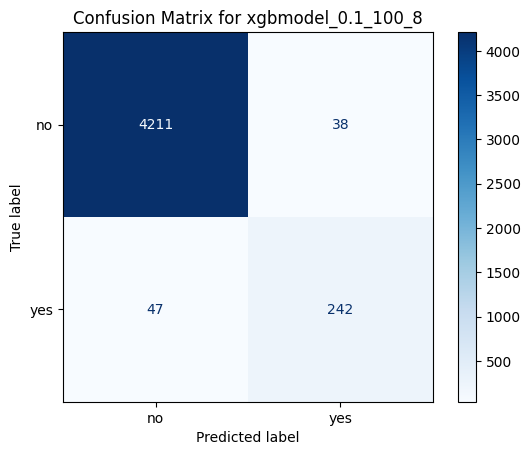



Evaluating xgbmodel_0.1_500_4...

xgbmodel_0.1_500_4 Test Accuracy: 0.9813
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4249
         1.0       0.86      0.85      0.85       289

    accuracy                           0.98      4538
   macro avg       0.92      0.92      0.92      4538
weighted avg       0.98      0.98      0.98      4538



<Figure size 400x200 with 0 Axes>

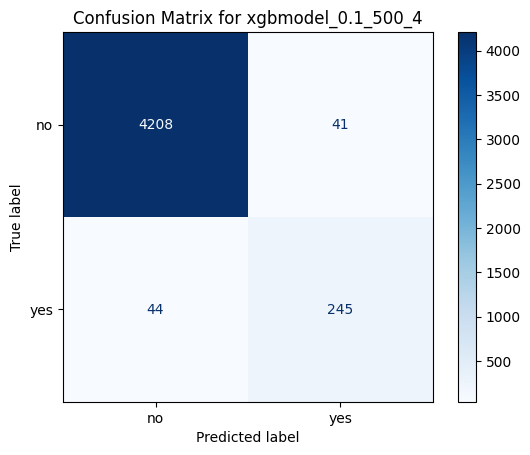



Evaluating xgbmodel_0.1_500_8...

xgbmodel_0.1_500_8 Test Accuracy: 0.9813
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4249
         1.0       0.86      0.84      0.85       289

    accuracy                           0.98      4538
   macro avg       0.93      0.91      0.92      4538
weighted avg       0.98      0.98      0.98      4538



<Figure size 400x200 with 0 Axes>

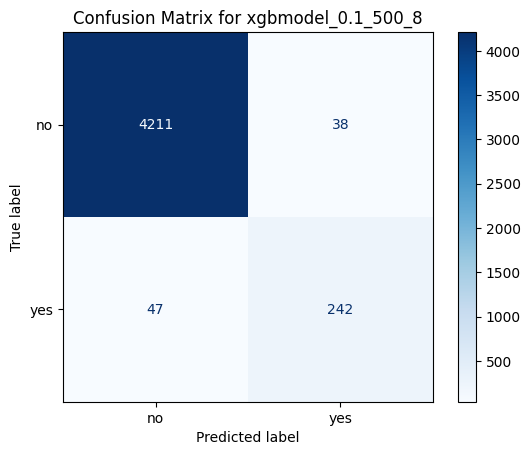



Evaluating xgbmodel_0.01_100_4...

xgbmodel_0.01_100_4 Test Accuracy: 0.9711
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      4249
         1.0       0.93      0.59      0.72       289

    accuracy                           0.97      4538
   macro avg       0.95      0.79      0.85      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

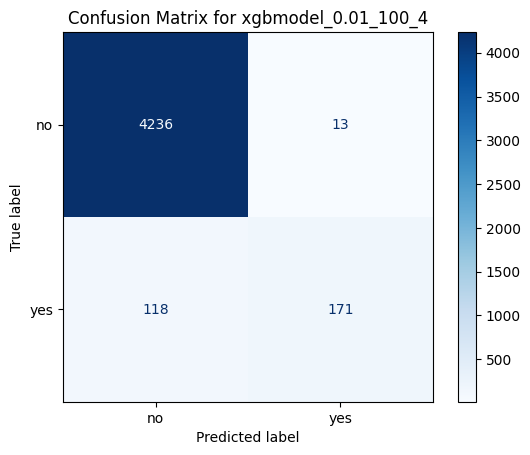



Evaluating xgbmodel_0.01_100_8...

xgbmodel_0.01_100_8 Test Accuracy: 0.9740
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      4249
         1.0       0.93      0.64      0.76       289

    accuracy                           0.97      4538
   macro avg       0.95      0.82      0.87      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

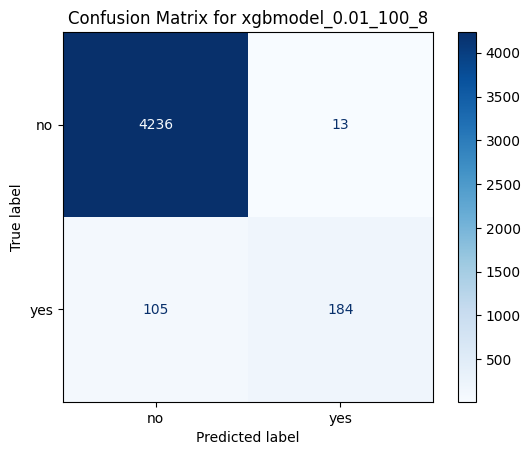



Evaluating xgbmodel_0.01_500_4...

xgbmodel_0.01_500_4 Test Accuracy: 0.9788
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4249
         1.0       0.86      0.79      0.83       289

    accuracy                           0.98      4538
   macro avg       0.93      0.89      0.91      4538
weighted avg       0.98      0.98      0.98      4538



<Figure size 400x200 with 0 Axes>

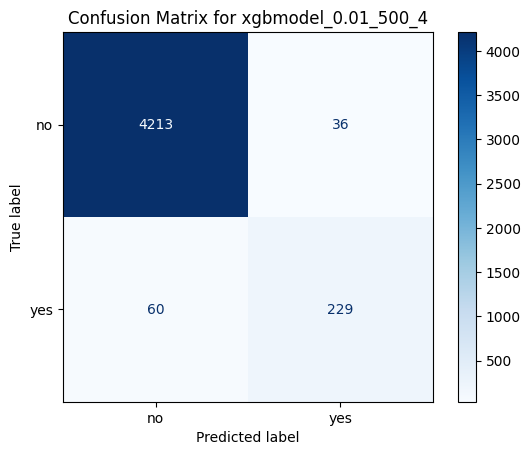



Evaluating xgbmodel_0.01_500_8...

xgbmodel_0.01_500_8 Test Accuracy: 0.9804
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4249
         1.0       0.87      0.82      0.84       289

    accuracy                           0.98      4538
   macro avg       0.93      0.90      0.92      4538
weighted avg       0.98      0.98      0.98      4538



<Figure size 400x200 with 0 Axes>

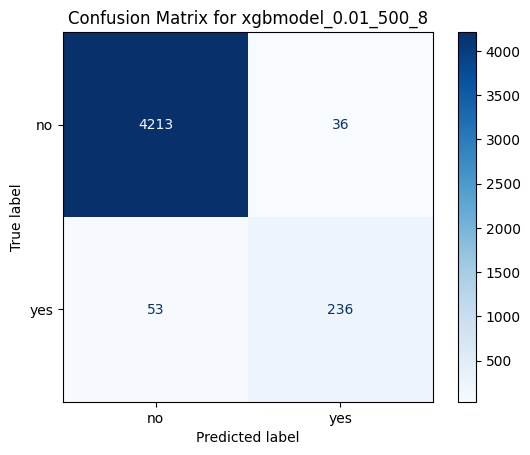

,model_name,train_accuracy,test_accuracy,train_loss,test_loss,F1_score,precision,recall,AUC
0,xgbmodel_0.1_100_4,0.9829,0.9797,0.0432,0.0569,0.9796,0.9795,0.9797,0.9086
1,xgbmodel_0.1_100_8,0.9949,0.9813,0.0209,0.0581,0.9811,0.9810,0.9813,0.9142
2,xgbmodel_0.1_500_4,0.9899,0.9813,0.0265,0.0553,0.9812,0.9812,0.9813,0.9191
3,xgbmodel_0.1_500_8,0.9957,0.9813,0.0146,0.0595,0.9811,0.9810,0.9813,0.9142
4,xgbmodel_0.01_100_4,0.9705,0.9711,0.1200,0.1219,0.9681,0.9701,0.9711,0.7943
5,xgbmodel_0.01_100_8,0.9780,0.9740,0.1078,0.1167,0.9717,0.9731,0.9740,0.8168
6,xgbmodel_0.01_500_4,0.9797,0.9788,0.0531,0.0622,0.9784,0.9782,0.9788,0.8920
7,xgbmodel_0.01_500_8,0.9906,0.9804,0.0316,0.0584,0.9801,0.9799,0.9804,0.9041


In [ ]:
results_list = []

random_seed=seed

# Loop through each model and perform evaluation
for model_name, model in xgb_models.items():
    print(f"\n\n{'='*50}\nEvaluating {model_name}...\n{'='*50}\n")


    # ******************************** Predictions *****************************
    train_pred_full = model.predict(X_train)
    test_pred_full = model.predict(X_test)


    #************************ Train and Test Evaluation ************************
    results = model.evals_result()
    train_loss_full = results['validation_0']['logloss'][-1]
    test_loss_full = results['validation_1']['logloss'][-1]

    train_accuracy_full = accuracy_score(y_train, train_pred_full)
    test_accuracy_full = accuracy_score(y_test, test_pred_full)

    auc_test_full = roc_auc_score(y_test, test_pred_full)

    print(f"{model_name} Test Accuracy: {test_accuracy_full:.4f}")
    print(classification_report(y_test, test_pred_full))

    f1_test_full = f1_score(y_test, test_pred_full, average='weighted')  # Weighted F1 score for test set
    precision_full = classification_report(y_test, test_pred_full, output_dict=True)['weighted avg']['precision']
    recall_full = classification_report(y_test, test_pred_full, output_dict=True)['weighted avg']['recall']


    #************************** Confusion Matrix and Plot **********************
    cm = confusion_matrix(y_test, test_pred_full)
    cfmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no", "yes"])
    plt.figure(figsize=(4, 2))
    cfmd.plot(cmap='Blues')
    plt.grid(False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


    results_list.append({
        "model_name": model_name,
        "train_accuracy": train_accuracy_full,
        "test_accuracy": test_accuracy_full,
        "train_loss": train_loss_full,
        "test_loss": test_loss_full,
        "F1_score": f1_test_full,
        "precision": precision_full,
        "recall": recall_full,
        "AUC": auc_test_full
    })


summary_df = pd.DataFrame(results_list)
summary_df = summary_df.round(4)
summary_df

###🔍 Test loss performance has improved significantly across all models (both on Neural Network and XGBoost), decreasing from around 0.7 to 0.5. The introduction of two new features has enhanced the overall performance metrics, indicating that these features provided valuable information, enabling the models to better capture underlying patterns in the data.

###🔍 AUC is slightly higher for Neural Networks, indicating better performance in separating positive and negative classes.

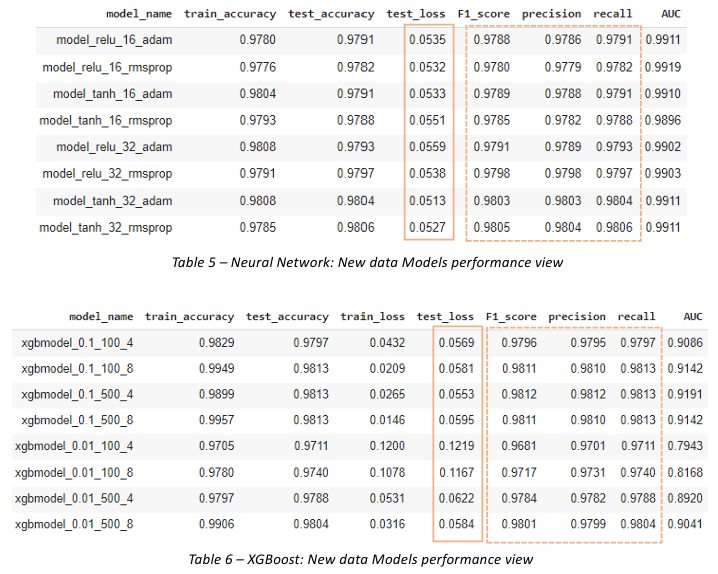

#**Features Importance - SHAP**

###**💡** In this part of the analysis I am chosing the XGBoost baseline model results to generate **insights about our predicted churn group**. With the use of SHAP it is possible to obtain information about what are the **key drivers of churn** based on the models' results.

In [ ]:
shap.initjs()

shap_ex = shap.TreeExplainer(xgb_model_full)
vals = shap_ex(X_test)
vals_df = pd.DataFrame(vals.values, columns=X_test.columns, index=X_test.index)
vals_df

,cwa,uac,coh,atp,age,cen_cardiff,cen_dublin,cen_durham,cen_holland,cen_huddersfield,...,pru_ucd,pru_uhu,pru_ule,pru_uli,pru_uop,pru_usi,pru_usr,pru_uss,pru_ust,pru_vua
18657,-2.604514,0.364314,-1.801316,-1.124508,0.034064,-0.001929,-0.008419,0.020558,0.012682,-0.096370,...,0.0,0.0,-0.001656,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16400,-3.416749,0.134248,-0.015318,-0.549482,-0.091010,-0.001929,-0.007644,0.030674,0.015122,-0.045193,...,0.0,0.0,-0.001656,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21943,-2.102406,0.380780,-0.039727,0.035293,0.344557,-0.004398,-0.007411,0.032025,0.017312,-0.041109,...,0.0,0.0,-0.001701,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21826,-3.871567,0.179877,0.444150,-1.544294,-0.257075,-0.001655,-0.008506,0.026204,0.014096,-0.006772,...,0.0,0.0,-0.001701,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13495,0.326303,0.196570,-0.872643,-0.024270,0.060140,-0.001929,-0.007675,0.038184,0.027202,-0.109068,...,0.0,0.0,-0.005423,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5460,-3.672443,-0.253893,-0.858631,-0.470227,0.462884,-0.001929,-0.007517,0.031404,0.017378,0.388899,...,0.0,0.0,-0.001701,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5618,6.097779,1.068982,-0.542063,1.343393,0.131194,-0.005531,-0.010140,0.004361,0.018315,-0.491482,...,0.0,0.0,-0.005980,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8655,-2.268841,0.536692,-3.042013,-0.502535,-0.158542,-0.001406,-0.007324,0.027600,0.017957,-0.094123,...,0.0,0.0,-0.000635,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5511,3.174372,0.105127,0.759959,-0.614370,-0.253863,-0.005531,-0.022265,0.005836,0.028733,-0.389620,...,0.0,0.0,-0.006026,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Checking for positive/negative contribution using SHAP values**

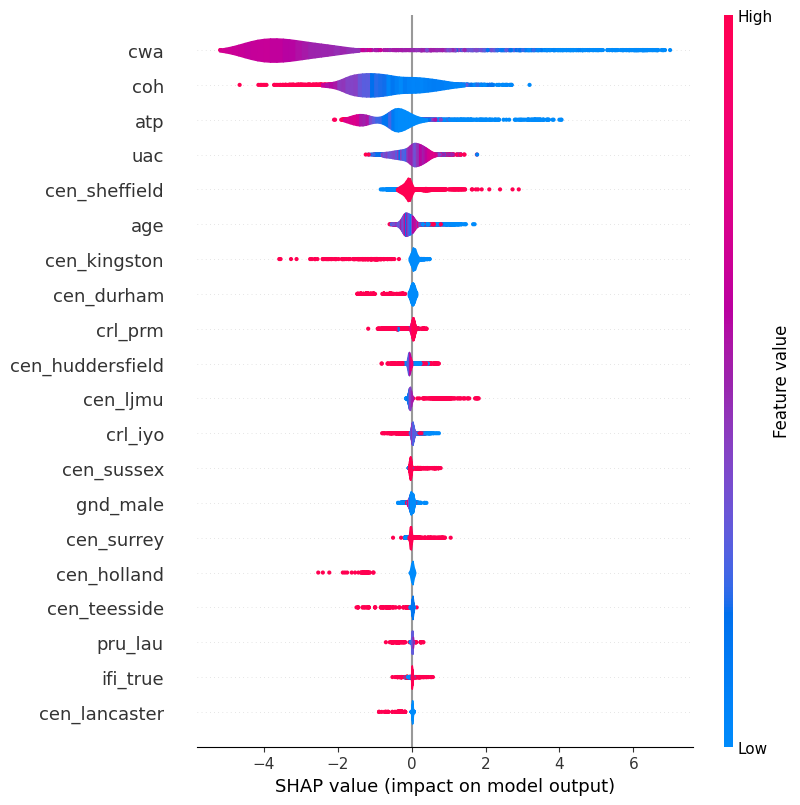

In [ ]:
shap.plots.violin(vals)

###🔍 The top predictor is *Credit Weighted Average (cwa)*, where higher values correspond to lower SHAP scores, indicating a negative relationship with student dropout. *Contact Hours (coh) and Attendance Percentage (atp)* show similar trends.  

###🔍 *Unauthorised Absence Count (uac)* is also a key factor but positively linked to dropout. *Centre names* like Sheffield and LJMU show a positive correlation with dropout, while Kingston and Durham trend negatively in SHAP values.

### Here are a few different visuals of a positive and a negative predictors:

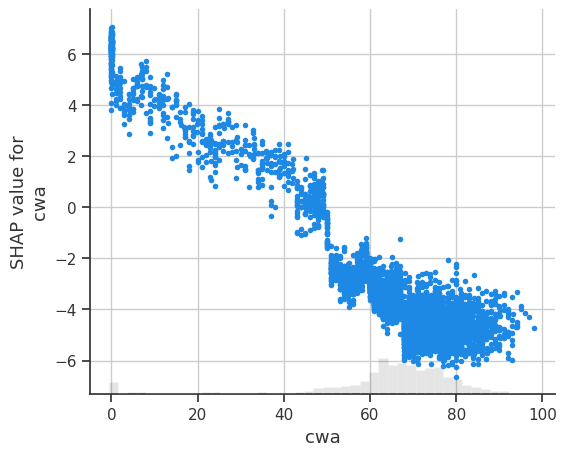

In [ ]:
shap.plots.scatter(vals[:, 'cwa'])

Lower likelyhood of churn for higher credit weighted average (opposite trend).

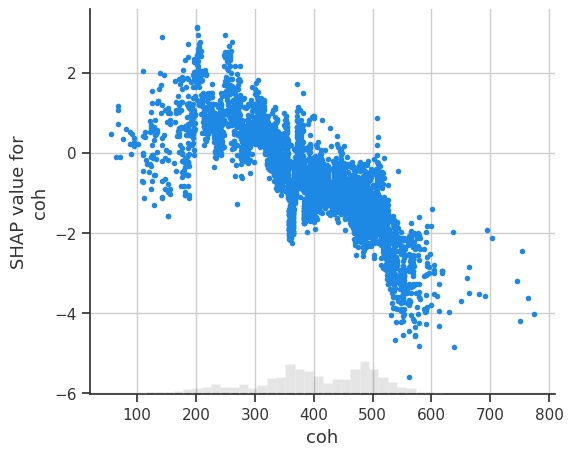

In [ ]:
shap.plots.scatter(vals[:, 'coh'])

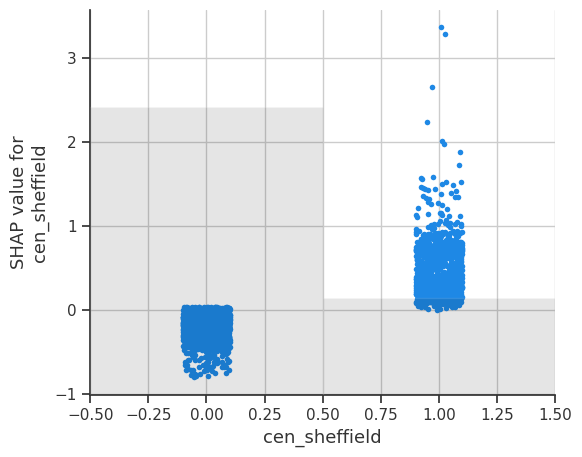

In [ ]:
shap.plots.scatter(vals[:, 'cen_sheffield'])

Higher likelyhood of dropout for Sheffield study centre.

### 🔍**Final Considerations**

###- Both modelling techniques perform well in predicting dropout, with Neural Networks slightly higher on AUC.

###- Choosing the model with the right balance between metrics and generalisation is the recommended choice;

###- Using models parameters, less complexity in the models (lower number of neurons, or less tree depth), in conjunction with a balanced learning rate, tend to generalize better and avoid overfitting;

###- Adding more, relevant, features to the model can improve its predictions providing the model with more information to learn from. Check with the business if more features can be analysed and added.